# TrendFinder

# Table of contents
1. [Introduction](#introduction)
2. [Some paragraph](#paragraph1)
    1. [Sub paragraph](#subparagraph1)
3. [Another paragraph](#paragraph2)

Nuvotronics
Black Swift

In [1]:
import pandas as pd
import json

from pytrends.request import TrendReq
import numpy as np
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from googlesearch import search_news
from newspaper import Article
from collections import Counter

import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a name = "paragraph1"></a>
Testing this is paragraph 1

In [2]:
## Peak detection algorithm utilizing Z-Scores for Robustness/Smoothing
def thresh_alg(y, lag, threshold, influence):
    # Checks to see if input y is shaped as an NumPy array vector and flattens if so
    if len(y.shape) > 1:
        y = y.reshape(y.size)
        
    ## Initializing our signal vector
    signals = np.zeros(len(y))
    ## Initializing our filtered series
    filteredY = np.zeros(len(y))
    filteredY[0:lag+1] = y[0:lag+1]
    ## Initialize our filters
    avgFilter = np.zeros(len(y))
    avgFilter[lag] = np.mean(y[0:lag+1])
    #avgFilter[lag] = np.median(y[0:lag+1])
    stdFilter = np.zeros(len(y))
    stdFilter[lag] = np.std(y[0:lag+1])
    #stdFilter[lag] = stats.median_absolute_deviation(y[0:lag+1])

    ## Looping over the rest of our data points in y (from y[lag+1] to y[y.size+1])
    for i in range(lag+1,y.size):
        ## Check to see if value is a threshold number of standard deviations away
        if np.abs(y[i] - avgFilter[i-1]) > threshold * stdFilter[i-1]:
            if y[i] > avgFilter[i-1]:
                ## For our case, we are only considering positive signals to signify a spike in relevancy
                ## for news-related events.
                signals[i] = 1;
            ## Making the influence lower
            ## TODO: Inplement a non-stationary transform instead (subtract the trend line?)
            filteredY[i] = influence * y[i] + (1-influence) * filteredY[i-1]
        else:
            ## No signal
            signals[i] = 0
            filteredY[i] = y[i]
        ## Adjusting our filters by moving our window
        avgFilter[i] = np.mean(filteredY[i-lag:i+1])
        #avgFilter[i] = np.median(y[i-lag:i+1])
        # Utilizing MAD instead as it is more robust for outliers
        #stdFilter[i] = 1.4826 * stats.median_absolute_deviation(y[i-lag:i+1])
        #stdFilter[i] = stats.median_absolute_deviation(y[i-lag:i+1])
        stdFilter[i] = np.std(filteredY[i-lag:i+1])
    return (signals, avgFilter, stdFilter)

In [18]:
pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ["Advent Innovations"]
pytrends.build_payload(kw_list, timeframe='today 3-m', geo='US', gprop='')

data = pytrends.interest_over_time()

## data = pytrends.get_historical_interest(kw_list, year_start=2019, month_start=6, day_start=29, hour_start=0, year_end=2019, month_end=7, day_end=1, hour_end=0, geo='US', sleep=60)
try:
    data.plot()
except Exception as e:
    print(e)
    
    

Empty 'DataFrame': no numeric data to plot


In [9]:
## Converting pandas data to np.array
import datetime

y=data.iloc[:,0].values

#for i in np.arange(np.size(y)):
#    if y[i] < 40:
#        y[i] = 39

## Settings for peak detection
lag = 1
threshold = 2.5
influence = 1


sig, avg, dev = thresh_alg(y, lag, threshold, influence)


x = pd.to_datetime(data.index)
#x = data.index
ix = range(lag, len(y))
lix = range(lag-1, len(y)-1)

ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(2, 1, 2)

fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5, forward=True)
fig.subplots_adjust(hspace=.6)

myFmt = mdates.DateFormatter('%m-%d')

ticks = pd.to_datetime(data.index[1:-1:10], unit = 'D')
ax1.set_xticks(ticks)
ax1.fill_between(x[ix],avg[lix]+threshold*dev[lix], facecolor='grey', alpha=0.1)
ax1.plot(x[ix], avg[lix], color = 'cyan')
ax1.plot(x[ix], avg[lix]+threshold*dev[lix], color='green', alpha=0.5)
ax1.plot(x, y, color='red', alpha=0.5)
ax1.legend(["Moving Average", "Moving Threshold", "Search Engine Data"], loc='best', fontsize='xx-small')
ax1.set_title('Interest over Time: ' + kw_list[0])
ax1.xaxis.set_major_formatter(myFmt)

ax2.set_xticks(ticks)
ax2.set_title("Peak Detection: " + kw_list[0])
ax2.step(x, sig, where='post')
ax2.xaxis.set_major_formatter(myFmt)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, fontsize=8)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, fontsize=8)
plt.savefig("Poster/pictures/nasa_std.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


IndexError: single positional indexer is out-of-bounds

NameError: name 'x' is not defined

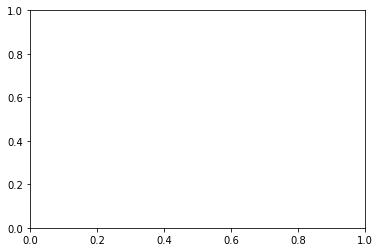

In [10]:
fig, ax = plt.subplots()

#for i in np.arange(np.size(y)):
#    if y[i] == 39:
#        y[i] = 0

ax.plot(x, y, color='red', alpha=0.5)
ax.step(x, (max(y)-min(y))/2*sig+min(y), where='post', alpha=1)
ax.axvline(x[lag], linestyle='--', color='black')
ax.legend(['Trend Data', 'Peaks', 'Lag Cut-off'])

myFmt = mdates.DateFormatter('%m-%d')

maj_ticks = pd.to_datetime(data.index[1:-1:5], unit = 'D')
min_ticks = pd.to_datetime(data.index[1:-1:1], unit = 'D')
ax.set_xticks(maj_ticks)
ax.set_xticks(min_ticks, minor=True)

ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, fontsize=10)
plt.title(kw_list[0] + " Trend Data w/ Peak Detections")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, fontsize=8)
plt.savefig("Poster/pictures/honeybee_overlay_mad.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()


In [106]:
df = pd.read_pickle('Fake-News-Classifier-master/saved_files/cleaned_df.pkl')

# Preparing the target and predictors for modeling

X_body_text = df['clean_text'].values
y = df['label'].values

tfidf = TfidfVectorizer(ngram_range=(1,2), max_df= 0.85, min_df= 0.01)

X_body_tfidf = tfidf.fit_transform(X_body_text)

indices = df.index.values

X_body_tfidf_train, X_body_tfidf_test, \
y_body_train, y_body_test, \
indices_body_train, indices_body_test = train_test_split(X_body_tfidf, y, indices, test_size = 0.2, random_state=42)

In [107]:
df.loc[indices_body_train].groupby('label').agg('count')

,author,link,published,text,title,clean_title,clean_text
label,,,,,,,
0,363,363,363,363,363,363,363
1,141,141,141,141,141,141,141


In [108]:
df.loc[indices_body_test].groupby('label').agg('count')

,author,link,published,text,title,clean_title,clean_text
label,,,,,,,
0,100,100,100,100,100,100,100
1,27,27,27,27,27,27,27


In [109]:
nb_body = MultinomialNB()
nb_body.fit(X_body_tfidf_train, y_body_train)

y_body_train_pred = nb_body.predict(X_body_tfidf_train)
# print metrics
print('Naive Bayes In Sample F1 and Accuracy Scores:')
print('F1 score {:.4}%'.format(f1_score(y_body_train, y_body_train_pred, average='macro')*100 ))
print ('Accuracy score {:.4}%'.format(accuracy_score(y_body_train, y_body_train_pred)*100))

Naive Bayes In Sample F1 and Accuracy Scores:
F1 score 99.51%
Accuracy score 99.6%


In [110]:
y_body_pred = nb_body.predict(X_body_tfidf_test)

# print metrics
print('Naive Bayes F1 and Accuracy Scores:')
print('F1 score {:.4}%'.format(f1_score(y_body_test, y_body_pred, average='macro')*100 ))
print ('Accuracy score {:.4}%'.format(accuracy_score(y_body_test, y_body_pred)*100))

Naive Bayes F1 and Accuracy Scores:
F1 score 98.81%
Accuracy score 99.21%


In [19]:
data = {}
data['keywords'] = {}

# if (sig[len(sig)-1])== 1:
if True:
    for keyword in kw_list:
        newsPaper = {
        "articles": []
        }
        for result in search_news(query=keyword, tld="co.in", num=10, stop=10, pause=2):
            try:
                article = {}
                news = Article(result)
                news.download()
                news.parse()
                news.nlp()
                article['link'] = result
                article['title'] = news.title
                article['text'] = news.text
                if news.publish_date:
                    article['published'] = news.publish_date.isoformat()
                else:
                    article['published'] = news.publish_date
                article['author'] = news.authors
                newsPaper['articles'].append(article)
                print(result)
                print(news.title)
                print("Searching for: ", keyword.lower().split())
                print("Article keywords: ", news.keywords)
                key_exact = lambda x: x in news.keywords
                key_contains = lambda x: subkey_contains(x)
                subkey_contains = lambda y: any(y in s for s in news.keywords)
                if all(map(key_exact, keyword.lower().split())):
                    print("This is an exact match to the search phrase")
                elif any(map(key_contains, keyword.lower().split())):
                    print("This is a partial match to the search phrase")
                else:
                    print("This does not match the search phrase")
                print("------------------------------------------------------------")
            except:
                print(result + " \nError: could not be downloaded.")
                print("------------------------------------------------------------")
        data['keywords'][keyword] = newsPaper
    try:
        fname = 'peak_articles.json'
        print('saving articles . . . in {}'.format(fname))
        with open(fname, 'w') as outfile:
            json.dump(data, outfile)
    except Exception as e: print(e)

https://urbanland.uli.org/economy-markets-trends/product-council-outlook-on-travel-trends/
Product Council Outlook on Travel Trends
Searching for:  ['advent', 'innovations']
Article keywords:  ['urban', 'development', 'council', 'outlook', 'product', 'trends', 'hotel', 'construction', 'cities', 'travel', 'hospitality', 'experience', 'tourism', 'airbnb']
This does not match the search phrase
------------------------------------------------------------
https://www.just-auto.com/news/denso-joins-ivado-to-enhance-its-rd-capabilities_id189696.aspx
Denso joins IVADO to enhance its R&D capabilities
Searching for:  ['advent', 'innovations']
Article keywords:  ['data', 'joins', 'research', 'rd', 'industry', 'ivado', 'montréal', 'lab', 'ai', 'capabilities', 'innovation', 'densos', 'denso', 'enhance']
This does not match the search phrase
------------------------------------------------------------
https://portnews24.com/servo-amplifier-market-know-the-key-growth-drivers-developments-and-innovati

In [142]:
fname = 'peak_articles.json'

with open(fname) as json_data:
    d = json.load(json_data)
    
for i, keyword in enumerate((list(d['keywords'])[:])):
    print(i, keyword)

0 CTI Computer Technology


In [143]:
# create a dataframe, with all of the articles, one row per article

for i, keyword in enumerate((list(d['keywords']))):
    articles = list(d['keywords'][keyword]['articles'])
    if i == 0:
        df_pred = pd.DataFrame.from_dict(articles)
    else:
        new_df = pd.DataFrame.from_dict(articles)
        df_pred = pd.concat([df, new_df], ignore_index = True)


In [144]:
df_pred.shape

(5, 5)

In [145]:
df_pred.head()

,author,link,published,text,title
0,[William Tyler],https://rivertonroll.com/news/2019/07/08/aspen...,2019-07-08T00:00:00,MIND C.T.I. (NASDAQ:MNDO) and Aspen Technology...,Head-To-Head Contrast: MIND C.T.I. (NASDAQ:MND...
1,[Rebecca Hunt],https://sundanceherald.com/2019/07/08/mind-c-t...,2019-07-08T00:00:00,Aspen Technology (NASDAQ:AZPN) and MIND C.T.I....,Contrasting Aspen Technology (NASDAQ:AZPN) and...
2,[Charles Blunt],https://mayfieldrecorder.com/2019/07/07/financ...,2019-07-07T00:00:00,MIND C.T.I. (NASDAQ:MNDO) and Formula Systems ...,MIND C.T.I. (NASDAQ:MNDO) versus Formula Syste...
3,"[Author Details, Alton On July]",http://industrynewsusa.com/17887/global-call-a...,None,Global Call Accounting Software Market 2019 Da...,Global Call Accounting Software Market 2019 Da...
4,[],https://patch.com/new-jersey/baskingridge/40-t...,2019-06-19T16:49:55-04:00,"BASKING RIDGE, NJ — Are you or somebody you kn...",40 Tech Job Openings Around Basking Ridge


In [146]:
%run Fake-News-Classifier-master/modules/cleaning_helper1.py 

<Figure size 432x288 with 0 Axes>

In [147]:
df_pred1 = df_pred.copy()
# function imported from python module
df_pred1 = clean_column(df_pred1, 'title', 'clean_title')
df_pred1 = clean_column(df_pred1, 'text', 'clean_text')
# function imported from python module
filtration(df_pred1, 'clean_title')
filtration(df_pred1, 'clean_text')

In [148]:
df_pred1.head()

,author,link,published,text,title,clean_title,clean_text
0,[William Tyler],https://rivertonroll.com/news/2019/07/08/aspen...,2019-07-08T00:00:00,MIND C.T.I. (NASDAQ:MNDO) and Aspen Technology...,Head-To-Head Contrast: MIND C.T.I. (NASDAQ:MND...,head to head contrast mind cti nasdaqmndo vers...,mind cti nasdaqmndo aspen technology nasdaqazp...
1,[Rebecca Hunt],https://sundanceherald.com/2019/07/08/mind-c-t...,2019-07-08T00:00:00,Aspen Technology (NASDAQ:AZPN) and MIND C.T.I....,Contrasting Aspen Technology (NASDAQ:AZPN) and...,contrasting aspen technology nasdaqazpn mind c...,aspen technology nasdaqazpn mind cti nasdaqmnd...
2,[Charles Blunt],https://mayfieldrecorder.com/2019/07/07/financ...,2019-07-07T00:00:00,MIND C.T.I. (NASDAQ:MNDO) and Formula Systems ...,MIND C.T.I. (NASDAQ:MNDO) versus Formula Syste...,mind cti nasdaqmndo versus formula systems 198...,mind cti nasdaqmndo formula systems 1985 nasda...
3,"[Author Details, Alton On July]",http://industrynewsusa.com/17887/global-call-a...,None,Global Call Accounting Software Market 2019 Da...,Global Call Accounting Software Market 2019 Da...,global call accounting software market 2019 da...,global call accounting software market 2019 da...
4,[],https://patch.com/new-jersey/baskingridge/40-t...,2019-06-19T16:49:55-04:00,"BASKING RIDGE, NJ — Are you or somebody you kn...",40 Tech Job Openings Around Basking Ridge,40 tech job openings around basking ridge,basking ridge nj somebody know looking work? p...


In [149]:
pred_body_text = df_pred1['clean_text'].values
pred_title_text = df_pred1['clean_title'].values

pred_body_tfidf = tfidf.transform(pred_body_text)

df_pred1['label'] = nb_body.predict(pred_body_tfidf)

df_pred1.head()


,author,link,published,text,title,clean_title,clean_text,label
0,[William Tyler],https://rivertonroll.com/news/2019/07/08/aspen...,2019-07-08T00:00:00,MIND C.T.I. (NASDAQ:MNDO) and Aspen Technology...,Head-To-Head Contrast: MIND C.T.I. (NASDAQ:MND...,head to head contrast mind cti nasdaqmndo vers...,mind cti nasdaqmndo aspen technology nasdaqazp...,0
1,[Rebecca Hunt],https://sundanceherald.com/2019/07/08/mind-c-t...,2019-07-08T00:00:00,Aspen Technology (NASDAQ:AZPN) and MIND C.T.I....,Contrasting Aspen Technology (NASDAQ:AZPN) and...,contrasting aspen technology nasdaqazpn mind c...,aspen technology nasdaqazpn mind cti nasdaqmnd...,0
2,[Charles Blunt],https://mayfieldrecorder.com/2019/07/07/financ...,2019-07-07T00:00:00,MIND C.T.I. (NASDAQ:MNDO) and Formula Systems ...,MIND C.T.I. (NASDAQ:MNDO) versus Formula Syste...,mind cti nasdaqmndo versus formula systems 198...,mind cti nasdaqmndo formula systems 1985 nasda...,0
3,"[Author Details, Alton On July]",http://industrynewsusa.com/17887/global-call-a...,None,Global Call Accounting Software Market 2019 Da...,Global Call Accounting Software Market 2019 Da...,global call accounting software market 2019 da...,global call accounting software market 2019 da...,1
4,[],https://patch.com/new-jersey/baskingridge/40-t...,2019-06-19T16:49:55-04:00,"BASKING RIDGE, NJ — Are you or somebody you kn...",40 Tech Job Openings Around Basking Ridge,40 tech job openings around basking ridge,basking ridge nj somebody know looking work? p...,0


In [112]:
distr_model = data.iloc[:,0].values

AttributeError: 'dict' object has no attribute 'iloc'

In [113]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "t", "gamma", "beta", "rayleigh",
                 "pareto", "alpha", "cauchy", "chi2", "expon", "laplace", "maxwell", ]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [460]:
get_best_distribution(distr_model[distr_model != 0])

p value for norm = 0.8629066417553631
p value for exponweib = 0.08294462109579923
p value for weibull_max = 0.008145257908307283
p value for weibull_min = 0.03772918428221477
p value for pareto = 0.9882610777467128
p value for genextreme = 0.997219694899973
p value for t = 0.8629398816182804
p value for gamma = 0.1100734024972233
p value for beta = 0.4945111168112733
p value for rayleigh = 0.7305959744101126
p value for pareto = 0.9882610777467128
p value for alpha = 0.9991936674628809
p value for cauchy = 0.9454746728655827
p value for chi2 = 0.003449975568007682
p value for expon = 0.9882610776435244
p value for laplace = 0.9611386481900571
p value for maxwell = 0.8245223793063367
Best fitting distribution: alpha
Best p value: 0.9991936674628809
Parameters for the best fit: (2.6129972366122027, 64.9998372422206, 41.46666734938442)


('alpha',
 0.9991936674628809,
 (2.6129972366122027, 64.9998372422206, 41.46666734938442))

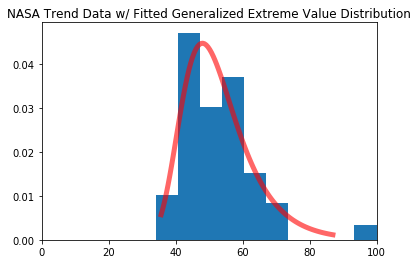

In [436]:
from scipy.stats import genextreme

a = -0.011964598414580523
b = 48.09331078967563
c = 8.221168534913915
scale = 26.6392

x = np.linspace(genextreme.ppf(0.01, a, b, c), genextreme.ppf(0.99, a, b, c), 100)
plt.xlim(right=100)
plt.hist(distr_model[distr_model != 0], density=True)
plt.title(keyword + " Trend Data w/ Fitted Generalized Extreme Value Distribution")
plt.plot(x, genextreme.pdf(x, a, b, c), 'r-', lw=5, alpha=0.6, label='alpha pdf')


In [ ]:

\w+\b(?<!, Inc|, LLC)

In [2]:
import csv
with open('LonglistFirms.csv', 'r') as f:
    reader = csv.reader(f)
    your_list = list(reader)

In [3]:
import re

flatten = lambda l: [item for sublist in l for item in sublist]
firms = flatten(your_list)

pattern = re.compile(r"\w+\b(?<!, Inc|, LLC)(?<! Ltd| LLC)(?![^\(]*\))")
firms = [" ".join(re.findall(pattern, firm)) for firm in firms]

print(firms)

['Firm', 'Creare', 'Environmental and Life Support Tech', 'Adventium Enterprises', 'IntelliEPI IR', 'M4 Engineering', 'Techshot', 'Metamagnetics', 'Skyre', 'ColdQuanta', 'MicroLink Devices', 'EM Photonics', 'Deployable Space Systems', 'ZONA Technology', 'CMSoft', 'Systems Technology', 'CFD Research Corporation', 'Prioria', 'Intelligent Automation', 'REI SYSTEMS', 'SibellOptics', 'Transition45 Technologies', 'Clear Science Corporation', 'ATSP Innovations', 'MesoScribe Technologies', 'Cornerstone Research Group', 'Invocon', 'Michigan Aerospace Corporation', 'The Innovation Laboratory', 'Aurora Flight Sciences Corporation', 'Physical Sciences', 'Technology in Blacksburg', 'CASCADE Technologies', 'ATA Engineering', 'Interdisciplinary Consulting Corporation', 'OPTINAV', 'Spectral Energies', 'Hersh Acoustical Engineering', 'JENTEK Sensors', 'Anasphere', 'Artium Technologies', 'Krystal Engineering', 'Innovative Technology Applications Co', 'Lynntech', 'Thermatin Industries', 'Combustion Resea

In [4]:
def find_acquisitions(firm):
    acquisition_matches = ["buys", "buy", "bought", "acquires", "acquire", "acquisitions", "acquisition", "purchases", "purchase", 
                           "merger", "merge", "merges, ""merging", "invested", "invests", "invest", "secure"]
    newsPaper = {
        "articles": []
    }
    contains_acquisition = lambda x: sub_contains(x)
    sub_contains = lambda y: all(y in s for s in acquisition_matches)
    print("Searching for firm: ", firm)
    for result in search_news(query=firm+" acquisition", tld="co.in", num=10, stop=5, pause=2):
        try:
            article = {}
            news = Article(result)
            news.download()
            news.parse()
            news.nlp()
            print("Downloaded: ", news.title)
            if any([x in acquisition_matches for x in news.title.lower().split()]):
                print("Acquisition found.")
                article['link'] = result
                article['title'] = news.title
                article['text'] = news.text
                article['firm'] = firm
                if news.publish_date:
                    article['published'] = news.publish_date.isoformat()
                else:                        
                    article['published'] = news.publish_date
                article['author'] = news.authors
                newsPaper['articles'].append(article)
            else:
                print("No acquisition found.")
            print("------------------------------------------------------------")
        except Exception as e:
            print(e)
            print(result + " \nError: could not be downloaded.")
            print("------------------------------------------------------------")

    return newsPaper

In [ ]:
data = {}
data['firms'] = {}
for firm in firms:
    data['firms'][firm] = find_acquisitions(firm)




Searching for firm:  Firm
Downloaded:  Maersk family company steps into renewables with wind firm acquisition
Acquisition found.
------------------------------------------------------------
Downloaded:  Maersk Firm to Buy Wind Turbine Supplier
Acquisition found.
------------------------------------------------------------
Downloaded:  Colorado Springs software company completes fourth acquisition in recent months
Acquisition found.
------------------------------------------------------------
Downloaded:  Private Equity Firm Finalizes Multi-Color Corp. Acquisition, Combines With WS Packaging
No acquisition found.
------------------------------------------------------------
Downloaded:  CIBC Agrees to Buy Milwaukee Boutique Bank Cleary Gull
Acquisition found.
------------------------------------------------------------
Searching for firm:  Creare
Downloaded:  Disney confirms it will ‘likely’ bundle Disney+, ESPN+, and Hulu for one price
No acquisition found.
-----------------------------

Downloaded:  Metamaterial Market Share, Industrial Analysis With Players Like Acentech, Echodyne Corp, Nanohmics, Plasmonics Inc, EM Infinity, MetaShield LLC, Teraview, AEgis Technologies, Protemics GmbH, SensorMe
No acquisition found.
------------------------------------------------------------
Searching for firm:  Skyre
Article `download()` failed with HTTPSConnectionPool(host='www.prnewswire.com', port=443): Read timed out. (read timeout=7) on URL https://www.prnewswire.com/news-releases/skyre-announces-the-worlds-first-commercially-available-high-pressure-electrochemical-hydrogen-separation-and-compression-system-300834562.html
https://www.prnewswire.com/news-releases/skyre-announces-the-worlds-first-commercially-available-high-pressure-electrochemical-hydrogen-separation-and-compression-system-300834562.html 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  New H2RENEW Compressor Separates and Purifies Hydrogen at Low Pressu

Downloaded:  Unusual Fungal Lesion Presenting as a Neoplastic Pediatric Tongue Mass
No acquisition found.
------------------------------------------------------------
Downloaded:  177Lu-DOTATATE PRRT in Recurrent Skull-Base Phosphaturic Mesenchymal Tumor Causing Osteomalacia: A Potential Application of PRRT Beyond Neuroendocrine Tumors
No acquisition found.
------------------------------------------------------------
Searching for firm:  Systems Technology
Downloaded:  FM:Systems Gains Advanced Workspace Analytics Through Rifiniti Acquisition
Acquisition found.
------------------------------------------------------------
Downloaded:  Raleigh-based FM:Systems acquires workspace optimization analytics firm
Acquisition found.
------------------------------------------------------------
Downloaded:  Cisco Buys Acacia for $2.6 Billion to Add Optical Technology
Acquisition found.
------------------------------------------------------------
Downloaded:  Cisco Intends to Acquire Acacia Communi

Article `download()` failed with HTTPSConnectionPool(host='www.prnewswire.com', port=443): Read timed out. (read timeout=7) on URL https://www.prnewswire.com/news-releases/military-robot-market-208716771.html
https://www.prnewswire.com/news-releases/military-robot-market-208716771.html 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Le projet urbain autour du futur stade de Nantes se dévoile
No acquisition found.
------------------------------------------------------------
Searching for firm:  MesoScribe Technologies
Downloaded:  Heat Flux Sensors Market 2025 Insights Analysis and 4 Company Profiles (OMEGA Engineering, Hioki, MesoScribe Technologies, GreenTEGMore) – BittCrunch
No acquisition found.
------------------------------------------------------------
Downloaded:  CVD Acquires Assets of MesoScribe Technologies, Inc.
Acquisition found.
------------------------------------------------------------
Downloaded:  CVD Equipment

Downloaded:  Continuous Wave Quantum Cascade Laser Market Growth Probability, Key Vendors and Future Scenario Up To 2024 – The Scripps Voice
No acquisition found.
------------------------------------------------------------
Downloaded:  Continuous Wave Quantum Cascade Laser Market Manufacturing Base, Sales Area and Its Competitors 2019-2025 – Market Reporter
No acquisition found.
------------------------------------------------------------
Downloaded:  Blog: New-age talent acquisition through HR software
Acquisition found.
------------------------------------------------------------
Searching for firm:  ATA Engineering
Downloaded:  360 Finance Announces Change to Board of Directors
No acquisition found.
------------------------------------------------------------
Downloaded:  Engineering group ATA acquires German cutting tools specialist Karnasch
Acquisition found.
------------------------------------------------------------
Downloaded:  ATA announces acquisition of Karnasch Profession

Downloaded:  Palo Alto Networks Completes Acquisition of Twistlock
Acquisition found.
------------------------------------------------------------
Downloaded:  Mark D. Mclaughlin Sells 40,000 Shares of Palo Alto Networks Inc (NYSE:PANW) Stock
No acquisition found.
------------------------------------------------------------
Downloaded:  Carlisle Acquires Ecco Finishing, Strengthens CFT Segment
Acquisition found.
------------------------------------------------------------
Article `download()` failed with 403 Client Error: Forbidden for url: https://www.forbes.com/sites/maribellopez/2019/07/09/5-changes-google-cloud-made-to-prove-its-an-enterprise-cloud-computing-company/ on URL https://www.forbes.com/sites/maribellopez/2019/07/09/5-changes-google-cloud-made-to-prove-its-an-enterprise-cloud-computing-company/
https://www.forbes.com/sites/maribellopez/2019/07/09/5-changes-google-cloud-made-to-prove-its-an-enterprise-cloud-computing-company/ 
Error: could not be downloaded.
--------------

Downloaded:  2019 – 2024 Parachute Market Covers Current Market Scenario, Market Dynamics with Market Drivers, Restraints, and Upcoming Opportunities
No acquisition found.
------------------------------------------------------------
Downloaded:  Commercial Parachutes Market Size, Share, Application Analysis, Regional Outlook, Growth Trends, Key Players, Competitive Strategies and Forecasts, 2019 to 2025 – Market Reporter
No acquisition found.
------------------------------------------------------------
Searching for firm:  New Electricity Transmission Software Solutions
Downloaded:  News Digest 4913
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Virtual Power Plant Market Anticipated to Reach $4.5 Billion by 2024
No acquisition found.
------------------------------------------------------------
Downloaded:  Jay Electronique acquired by Conductix-Wampfler
No acquisition found.
-------------------------------------------------------

Downloaded:  Membrane Electrode Assemblies Market Growth, Market insights and Forecast upto 2018  2023
No acquisition found.
------------------------------------------------------------
Downloaded:  ACON Investments and Torreal Acquire Germaine de Capuccini
Acquisition found.
------------------------------------------------------------
Downloaded:  Rubix to acquire Schäfer Technik
Acquisition found.
------------------------------------------------------------
Downloaded:  Europe’s largest MRO firm, IPH Brammer, is reborn as Rubix
No acquisition found.
------------------------------------------------------------
Searching for firm:  US Hybrid Corporation
Downloaded:  International Business Machines Corporation: IBM Closes Landmark Acquisition of Red Hat for $34 Billion; Defines Open, Hybrid Cloud Future
Acquisition found.
------------------------------------------------------------
Downloaded:  Auto Stock Roundup: June U.S. Auto Sales Decline, TSLA Sees Record-High Production
No acquis

Downloaded:  Israeli auto-tech startups proliferate
No acquisition found.
------------------------------------------------------------
Searching for firm:  Virtual AeroSurface Technologies
Downloaded:  Unique Fixture System Provides Robust CMM Solution – Metrology and Quality News
No acquisition found.
------------------------------------------------------------
Downloaded:  Cruise-capable rotorcraft exploits the performance of composites
No acquisition found.
------------------------------------------------------------
Downloaded:  Boardman offers upgrades and new models for 2016
No acquisition found.
------------------------------------------------------------
Searching for firm:  Creative Aero Engineering Solutions
Downloaded:  CCDC’s road map to modernizing the Army: the network
No acquisition found.
------------------------------------------------------------
Downloaded:  Emery Sapp & Sons Continues to Grow
No acquisition found.
----------------------------------------------------

/Users/user/Academics/NASA/Apis/tutorial-env/lib/python3.5/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Downloaded:  Cisco’s Acacia Acquisition Will Strengthen Its All-Important Service Provider Business
Acquisition found.
------------------------------------------------------------
Downloaded:  Cisco goes deeper into photonic, optical technology with $2.6B Acacia buy
Acquisition found.
------------------------------------------------------------
Downloaded:  Acacia Communications' stock rockets after $2.6 billion Cisco buyout deal
No acquisition found.
------------------------------------------------------------
Downloaded:  Cisco to buy Acacia for US$2.6 billion, adding optical technology
Acquisition found.
------------------------------------------------------------
Searching for firm:  Qualtech Systems
Downloaded:  Enterprise Resource Planning Technologies Market Projected to Acquire Fastest Growth at a CAGR of 16.14% by Top Competitors Microsoft Corporation, Oracle Corporation, Qad Inc., Qualtec Systems Ltd, am
Acquisition found.
-----------------------------------------------------

Downloaded:  Mechanical spectroscopy of insect swarms
No acquisition found.
------------------------------------------------------------
Downloaded:  McDonald's Bites on Big Data With $300 Million Acquisition
Acquisition found.
------------------------------------------------------------
Downloaded:  Global Spa Luxury Furniture Market 2019-2025 Manufacturers, to study the Capacity, Value, Share and Development Plans in Future – Tribaux
No acquisition found.
------------------------------------------------------------
Downloaded:  Hair Salon Market Analysis by Major Companies, Segmentation, Market Dynamics & Trends – CW57.TV
No acquisition found.
------------------------------------------------------------
Downloaded:  Badger, ClearView, Avalution, Assurance Software – Top News Desk
No acquisition found.
------------------------------------------------------------
Searching for firm:  N R Engineering
Downloaded:  Spectrum Effect Appoints John Saw to Its Board of Directors
No acquisition

Downloaded:  Worldwide IC Socket Market Analysis & Forecast 2019-2024 - Growing Demand for Electronics with High Computing Power Drives Growth
No acquisition found.
------------------------------------------------------------
Downloaded:  The IC Socket Market: Global Growth, Trends, and Forecast (2019-2024) - ResearchAndMarkets.com
No acquisition found.
------------------------------------------------------------
Downloaded:  USB Sockets Market 2019 With Top Countries Data : Worldwide Overview By Industry Size, Market Share, Future Trends, Growth Factors and Leading Players Research Report Analysis and Forecast to 2025
No acquisition found.
------------------------------------------------------------
Downloaded:  Elsevier Closes its Acquisition of Aries Systems
Acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='www.prnewswire.com', port=443): Read timed out. (read timeout=7) on URL https://www.prnew

Downloaded:  Nano Metal Powder Market Analysis by Major Vendors, Segmentation, Market Dynamics, Historical Data & Future Trends
No acquisition found.
------------------------------------------------------------
Searching for firm:  Micro Cooling Concepts
Downloaded:  Consumer Protection
No acquisition found.
------------------------------------------------------------
Downloaded:  Global InGaAs Camera Market competitive Data 2019: Hamamatsu, First Sensor, Jenoptik, Teledyne Technologies, Luna Innovations, Lumentum Holdings – Daily Industry News
No acquisition found.
------------------------------------------------------------
Downloaded:  Addendum to Evolution: The Origins of the World
No acquisition found.
------------------------------------------------------------
Downloaded:  STULZ and Cloud&Heat team up with Watercooled Micro Data Center
No acquisition found.
------------------------------------------------------------
Downloaded:  Directly-cooled lighter-weight EV motor made with

Downloaded:  Tantalum Recycling expands processing capacity
No acquisition found.
------------------------------------------------------------
Downloaded:  Norsk Hydro invests in additional testing equipment
Acquisition found.
------------------------------------------------------------
Searching for firm:  Faraday Technology
Downloaded:  Chinese firm makes insane $23 billion investment in production of 1 million EVs/yr and 500 GWh of batteries
No acquisition found.
------------------------------------------------------------
Downloaded:  Chinese NEVS buys leading in-wheel electric motor manufacturer
Acquisition found.
------------------------------------------------------------
Downloaded:  Exclusive: Evergrande’s EV Drive Hits Another Speed Bump
No acquisition found.
------------------------------------------------------------
Downloaded:  10 Questions for Harry Martin
No acquisition found.
------------------------------------------------------------
Article `download()` failed with 

Downloaded:  Metamaterial Market Share, Industrial Analysis With Players Like Acentech, Echodyne Corp, Nanohmics, Plasmonics Inc, EM Infinity, MetaShield LLC, Teraview, AEgis Technologies, Protemics GmbH, SensorMe
No acquisition found.
------------------------------------------------------------
Searching for firm:  Southwest Sciences
Downloaded:  NASA Selects 12 New Lunar Science, Technology Investigations
No acquisition found.
------------------------------------------------------------
Downloaded:  Canadian Metals signs agreement to acquire FeTiV Minerals’ interest on 5 iron projects in Quebec, and appoints Gérald Panneton as Chairman & CEO
Acquisition found.
------------------------------------------------------------
Downloaded:  Status Update: Anaheim-based aerospace firm Acra acquired by Texas firm
No acquisition found.
------------------------------------------------------------
Downloaded:  Three projects tapped by NASA for lunar exploration have Boulder ties
No acquisition fo

Downloaded:  Top incident response tools to boost network protection
No acquisition found.
------------------------------------------------------------
Downloaded:  No, Bitcoin Isn’t Really Selling for $76,000 in Zimbabwe: Analysts
No acquisition found.
------------------------------------------------------------
Downloaded:  The Hidden Cost of GoFundMe Health Care
No acquisition found.
------------------------------------------------------------
Searching for firm:  TDA Research
Downloaded:  Nanotube Electronics Market Insights by Industry Volume, Opportunities, Type, Product Analysis, and Application – The Connection
No acquisition found.
------------------------------------------------------------
Downloaded:  Fullerene Market Overview with Detailed Analysis, Competitive Landscape and Forecast to 2025 – MelodyReports
No acquisition found.
------------------------------------------------------------
Downloaded:  Top Leading Countries, Companies, Consumption, Drivers, Trends, Forces A

Downloaded:  Fiber Optic Development Tools Market Growth and Status Explored in a New Research Report: Analog Devices Inc , Broadcom Limited , Finisar , Glenair , Maxim Integrated – A Technology Market
No acquisition found.
------------------------------------------------------------
Searching for firm:  Sequent Logic
Downloaded:  T-Mobile-Sprint merger scrutinized during House hearing
Acquisition found.
------------------------------------------------------------
Downloaded:  T-Mobile CFO talks plans for Sprint network following merger
Acquisition found.
------------------------------------------------------------
Downloaded:  T-Mobile CEO John Legere continues push for Sprint merger, claims more than 5,000 customer care jobs added by 2021
No acquisition found.
------------------------------------------------------------
Downloaded:  Department of Justice reportedly recommends blocking T-Mobile-Sprint merger
Acquisition found.
----------------------------------------------------------

Downloaded:  Global Off-grid Remote Sensing Power Systems Market Trend 2019 – Acumentrics, Ensol Systems, HES, SFC Energy, Tycon Systems, Victron Energy – Industry News Center
No acquisition found.
------------------------------------------------------------
Downloaded:  Video Highlights from Nuremberg’s Sensor+Test 2019
No acquisition found.
------------------------------------------------------------
Searching for firm:  Intelligent Fiber Optic Systems Corporation
Downloaded:  Fiber Optic Connectivity System Market Highlighting Regional Revenue Share Dominance during 2019-2024 future Analysis by Adtell Integration, Adtran, ADVA Optical Networking, Broadcom, Ciena Corporatio
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='financialplanning24.com', port=443): Max retries exceeded with url: /fiber-optic-test-equipment-market-to-record-ascending-growth-by-2027/ (Caused by SSLError(SSLError("bad 

Downloaded:  Midea Faces Headwinds in German Acquisitions
Acquisition found.
------------------------------------------------------------
Searching for firm:  Opto Knowledge Systems
Downloaded:  Global Optical Isolators Market Segment Analysis by Key Players, Drivers, Regional, Competitive Landscape & Forecast To 2024 – The Connection
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPConnectionPool(host='californiaoracle.com', port=80): Read timed out. (read timeout=7) on URL http://californiaoracle.com/pharmaceutical-isolators-market-global-market-research-in-depth-analysis-2019-2024/41334/
http://californiaoracle.com/pharmaceutical-isolators-market-global-market-research-in-depth-analysis-2019-2024/41334/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Gallium Nitride Semiconductor Device 3150 Market Opportunities, Top Vedors, Industry Survey, Capital Inves

Downloaded:  Tonix Pharmaceuticals Holding Corp (TNXP) Research Report
No acquisition found.
------------------------------------------------------------
Article `download()` failed with 416 Client Error: Requested Range Not Satisfiable for url: https://www.streetinsider.com/SEC+Filings/Form+PRER14A+MTech+Acquisition+Corp/15499029.html on URL https://www.streetinsider.com/SEC+Filings/Form+PRER14A+MTech+Acquisition+Corp/15499029.html
https://www.streetinsider.com/SEC+Filings/Form+PRER14A+MTech+Acquisition+Corp/15499029.html 
Error: could not be downloaded.
------------------------------------------------------------
Searching for firm:  Electric Power Systems
Downloaded:  Ameren gives $25,000 for SIUE power system lab
No acquisition found.
------------------------------------------------------------
Downloaded:  Sager Electronics to Acquire Technical Power Systems
Acquisition found.
------------------------------------------------------------
Downloaded:  Federal judge won&#39;t throw o

Downloaded:  Node ‘coliving’ comes to rent-controlled Echo Park bungalow courts
No acquisition found.
------------------------------------------------------------
Downloaded:  Cancer Season 2019 Is About Nurturing Your Inner World & Trusting Your Instincts
No acquisition found.
------------------------------------------------------------
Downloaded:  How octopus arms make decisions
No acquisition found.
------------------------------------------------------------
Searching for firm:  Xwing
Downloaded:  The Supersonic Jet Is Almost Here
No acquisition found.
------------------------------------------------------------
Downloaded:  Lockheed wins Support Contract for FFG(X) | Russia to Purchase two Yasen Class Subs | USS Montgomery Deploys to Pacific
Acquisition found.
------------------------------------------------------------
Downloaded:  These Are All the Businesses You Never Knew Were Owned by Amazon
No acquisition found.
------------------------------------------------------------
D

You must `download()` an article first!
https://data-economy.com/cloud-computing-pivoting-to-face-the-change/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Accelerate EMI Qualification of Automotive Touchscreens with New Capacitive Touch Controllers
No acquisition found.
------------------------------------------------------------
Downloaded:  Automotive Robotics Market – Research Methodology & Rapid Growth Till 2028 – Pioneer Reporter
No acquisition found.
------------------------------------------------------------
Downloaded:  3 Top Large-Cap Stocks to Buy in June -- The Motley Fool
Acquisition found.
------------------------------------------------------------
Searching for firm:  UAVradars
Downloaded:  Camcopter S-100 UAV
No acquisition found.
------------------------------------------------------------
Downloaded:  Teal Predicts $100 Billion Military Spending on Drones, UCAVs over 10 years
No acquisition found.
--------

Downloaded:  Summit Companies Further Expands Presence In Western U.S. With Entry Into Utah
No acquisition found.
------------------------------------------------------------
Downloaded:  Town of Herndon Appoints New Director of Public Works
No acquisition found.
------------------------------------------------------------
Downloaded:  House GOP plan blocks state work on Gordie Howe Bridge
No acquisition found.
------------------------------------------------------------
Searching for firm:  Lawrie Technology
Downloaded:  DXC Technology Completes Acquisition of Leading Digital Innovator Luxoft
Acquisition found.
------------------------------------------------------------
Downloaded:  DXC Technology completes acquisition of Luxoft, a digital innovator
Acquisition found.
------------------------------------------------------------
Downloaded:  Global HAZMAT Packaging Market Review & Outlook 2017-2026 - A $13.62 Billion Opportunity Analysis by Material Type, Product Type, Class, Applicat

Downloaded:  
No acquisition found.
------------------------------------------------------------
Searching for firm:  CGH Technologies
Article `download()` failed with HTTPSConnectionPool(host='risemedia.net', port=443): Max retries exceeded with url: /2019/07/10/bioinformatics-market-outlook-industry-size-with-illumina-agilent-technologies-perkinelmer-inc-qiagen/ (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),)) on URL https://risemedia.net/2019/07/10/bioinformatics-market-outlook-industry-size-with-illumina-agilent-technologies-perkinelmer-inc-qiagen/
https://risemedia.net/2019/07/10/bioinformatics-market-outlook-industry-size-with-illumina-agilent-technologies-perkinelmer-inc-qiagen/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Industry Analysis On Bioinformatics Market Trends With Illumina, Dassault Systèmes, QIAGEN, PerkinElmer, I

Downloaded:  High brightness mid-infrared laser expands horizon of spectroscopic analytical technique
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='financialplanning24.com', port=443): Max retries exceeded with url: /confocal-laser-scanning-microscope-market-growth-prospects-demand-and-forecast-2017-2025/ (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://financialplanning24.com/confocal-laser-scanning-microscope-market-growth-prospects-demand-and-forecast-2017-2025/
https://financialplanning24.com/confocal-laser-scanning-microscope-market-growth-prospects-demand-and-forecast-2017-2025/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  High-Brightness Mid-IR Laser Expands Horizon of Spectroscopic Technique
No acquisition found.
------------------------------------------------------------
Se

Downloaded:  Global Multiple Remote Tower Market Size, Applications, Technological Improvements, Future Expectations and Forecast 2019-2025 – Pioneer Reporter
No acquisition found.
------------------------------------------------------------
Searching for firm:  University Technical Services
Downloaded:  Department of Defense Contracts for July 9, 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  TechCanary acquired by Illinois firm
No acquisition found.
------------------------------------------------------------
Downloaded:  M&A Moves: EveryAction makes it's third acquisition in six weeks
Acquisition found.
------------------------------------------------------------
Downloaded:  Enterprise Rent-A-Car, National Car Rental brands honored by travel professionals for superior customer service
No acquisition found.
------------------------------------------------------------
Downloaded:  The Central Station Appoints Jeremy Sadler as Gene

Downloaded:  Matthew Lindsay: Why Hibs saviour Sir Tom Farmer is an all-time Easter Road great
No acquisition found.
------------------------------------------------------------
Downloaded:  Finance & Development
No acquisition found.
------------------------------------------------------------
Downloaded:  Legals for July 11, 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  Ormond Beach buys S. Old Kings Road residential property for $285,000
Acquisition found.
------------------------------------------------------------
Searching for firm:  WIRELESS SENSOR TECHNOLOGIES
Downloaded:  IDT and Electronic Design Chemnitz Collaborate on Implementing Wireless Communication and Sensor Solutions for Industry 4.0
No acquisition found.
------------------------------------------------------------
Downloaded:  Wireless Sensor Networks (WSN) Market - Global Outlook Report 2017-2026 - Market is Expected to Grow at a CAGR of 19.7% - ResearchAndMark

Downloaded:  Yoga established as a series of principles to shape communities
No acquisition found.
------------------------------------------------------------
Downloaded:  No Assembly elections in Jammu and Kashmir now, only Parliamentary polls: CEC Sunil Arora
No acquisition found.
------------------------------------------------------------
Downloaded:  Business Strategy and Rising Status of Top Key Players Forecast to 2024 – Market Reporter
No acquisition found.
------------------------------------------------------------
Searching for firm:  Thoughtventions Unlimited
Searching for firm:  VIP Sensors
Downloaded:  Fresh off a $530M round, Aurora acquires lidar startup Blackmore – TechCrunch
Acquisition found.
------------------------------------------------------------
Downloaded:  Samsara banks $100M at a $3.6B valuation for its internet-connected sensors – TechCrunch
No acquisition found.
------------------------------------------------------------
Downloaded:  Microsoft delves de

Downloaded:  Tyvak Nano-Satellite Systems, NanoAvionika, Interorbital Systems – Review Stocks Value
No acquisition found.
------------------------------------------------------------
Downloaded:  Market Insights of Nanosatellite and Microsatellite Market by Top Key Companies, Size, Marketing Channels & Market Dynamics Forces – The Connection
No acquisition found.
------------------------------------------------------------
Downloaded:  CubeSat Market Overview and Forecast Report 2019 : Key Players- Tyvak Nano-Satellite Systems, NanoAvionika, Interorbital Systems
No acquisition found.
------------------------------------------------------------
Downloaded:  Terran Orbital raises $36 million in Series B investment round
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='marketnewsbizz.com', port=443): Max retries exceeded with url: /2019/06/nano-satellite-market-top-key-players-clyde-space-ltd-inno

Downloaded:  ZEISS invest in LiDAR company Bridger Photonics
Acquisition found.
------------------------------------------------------------
Downloaded:  Leak Detection for Oil and Gas Market by Product & Application Segmentation, Major Players, Size, Market Dynamics & Forecast 2024 – The Connection
No acquisition found.
------------------------------------------------------------
Downloaded:  The Missoula law office behind Montana’s biggest tech deal – and other startups
No acquisition found.
------------------------------------------------------------
Searching for firm:  Litespar
Searching for firm:  Vanguard Space Technologies
Downloaded:  Kensington Vanguard Acquires Majority Stake in Legal 1031 Exchange Services
Acquisition found.
------------------------------------------------------------
Downloaded:  Apollo 11 moon mission drew space-related companies to Central Florida
No acquisition found.
------------------------------------------------------------
Downloaded:  5 Unbeatable

Downloaded:  Market Insights of Metal Oxide Nanopowders Market by Top Key Companies, Size, Marketing Channels & Market Dynamics Forces – CW57.TV
No acquisition found.
------------------------------------------------------------
Downloaded:  Carbon Dioxide Generators Market Size Development Trends, Analysis and Forecast by 2025
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='portnews24.com', port=443): Max retries exceeded with url: /titanium-dioxide-nano-materials-market-2019-industry-size-by-global-major-companies-profile-growth-competitive-landscape-and-key-regions-2026market-reports-world/98342/ (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://portnews24.com/titanium-dioxide-nano-materials-market-2019-industry-size-by-global-major-companies-profile-growth-competitive-landscape-and-key-regions-2026market-reports-world/98342/
https://portnews24.

Downloaded:  Global Industrial Control System Security Market Research and Forecast 2019-2025 Cisco, Honeywell, Juniper, Siemens, Rockwell, Tofino Security – Tribaux
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Machine Control Systems Market Deep Analysis 2019-2027: Leica Geosystems AG, Schneider Electric Se, Topcon Corporation – Daily News Insights
No acquisition found.
------------------------------------------------------------
Searching for firm:  AZ Technology Inc
Downloaded:  Xalles and BlockDrive to Build Innovation into Financial Services Technology
No acquisition found.
------------------------------------------------------------
Downloaded:  Mesa OKs deal to bring $1B Google site to city
No acquisition found.
------------------------------------------------------------
Downloaded:  Taronis Generates $2.05 Million in May 2019 Revenues
No acquisition found.
------------------------------------------------------------
Dow

Downloaded:  Recent Research Study: Copper Floor Drain Market Forecast 2019-2025: Top Companies, Growth Factors, Classification, Regional Analysis, Development Factors – A Technology Market
No acquisition found.
------------------------------------------------------------
Searching for firm:  Rocket Propulsion Systems
Downloaded:  Apollo 11 moon mission drew space-related companies to Central Florida
No acquisition found.
------------------------------------------------------------
Downloaded:  Russia Offers India Joint Development of New Diesel-Electric Attack Submarine
No acquisition found.
------------------------------------------------------------
Downloaded:  Hispasat buyer secures 500M euro credit line • ESA, Polish firms study rocket tech • CETel buys UK teleport operator
Acquisition found.
------------------------------------------------------------
Downloaded:  Ariane 5 rocket arrives at launch pad with two TV broadcast satellites – Spaceflight Now
No acquisition found.
-----

Downloaded:  Global Ozone Sterilizer Market Share, Size, Demand and Growth Analysis – A Technology Market
No acquisition found.
------------------------------------------------------------
Searching for firm:  FuelCellsEtc
Downloaded:  Fuel Cell Membranes Market with Future Prospects, Industry Capacity, Economic Aspect and Forecast To 2024 – The Connection
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='financialplanning24.com', port=443): Max retries exceeded with url: /membrane-electrode-assemblies-mea-for-fuel-cells-market-growth-forecast-to-2025-by-top-key-players-3m-dupont-fuel-cells-etc-freudenberg-gore-johnson-matthey-ballard/ (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://financialplanning24.com/membrane-electrode-assemblies-mea-for-fuel-cells-market-growth-forecast-to-2025-by-top-key-players-3m-dupont-fuel-cells-etc-freudenberg-gore-jo

/Users/user/Academics/NASA/Apis/tutorial-env/lib/python3.5/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Downloaded:  Barracuda Makes Wider MSP Play With Acquisition Of Avast's Managed Workplace RMM
Acquisition found.
------------------------------------------------------------
Downloaded:  HPE SimpliVity hyper-converged FAQs get answered
No acquisition found.
------------------------------------------------------------
Searching for firm:  Tetra Research Corporation
Downloaded:  Tetra Bio-Pharma’s Management Provides Corporate Update Ahead of Annual General Meeting
No acquisition found.
------------------------------------------------------------
Downloaded:  New Hemp Energy Drink to be offered to consumers in cannabis accessory stores, vapes stores, and kiosks in Canada and the US
No acquisition found.
------------------------------------------------------------
Downloaded:  Global UHT Processing Market 2019 Research Report By Top Vendors like Tetra Laval International, GEA Group, Alfa Laval, SPX FLOW, Inc., Elecster Oyj, Shanghai Triowin Intelligent Machinery Co.,Ltd, Mi
No acquisition

Downloaded:  Hospital that closed Skyhaven Surgery Center delayed billing for 10 months due to EHR rollout — 5 insights
No acquisition found.
------------------------------------------------------------
Downloaded:  Frisbie Hospital president/CEO retiring
No acquisition found.
------------------------------------------------------------
Downloaded:  New England’s Regional Defense Industry Collaboration
No acquisition found.
------------------------------------------------------------
Downloaded:  NH airport funding stalled over jet fee debate
No acquisition found.
------------------------------------------------------------
Searching for firm:  Innovative Space Technologies
Downloaded:  ABI Research Announces the Hot Tech Robotics Innovators Advancing Mobility, Lowering Adoption Barriers & Improving Collaboration with Humans
No acquisition found.
------------------------------------------------------------
Downloaded:  Google to Boost Data Storage Offerings With Elastifile Buyout
No ac

Downloaded:  AbbVie to Acquire Allergan in Transformative Move for Both Companies
Acquisition found.
------------------------------------------------------------
Downloaded:  Botox Maker Allergan Is Sold to AbbVie in $63 Billion Deal
No acquisition found.
------------------------------------------------------------
Searching for firm:  Ricardo Defense
Downloaded:  Kilgore's Freedom Communication acquired by Astronics in $22 million deal
No acquisition found.
------------------------------------------------------------
Downloaded:  New York-based aerospace corp acquires Kilgore communications company
Acquisition found.
------------------------------------------------------------
Downloaded:  What We've Learned About Each NFL Team so Far This Offseason
No acquisition found.
------------------------------------------------------------
Downloaded:  U.S. Naval Research Laboratory Welcomes 40th Commander
No acquisition found.
------------------------------------------------------------
Downl

Downloaded:  India- Space Habitat Market to Witness Huge Growth by 2025 | Lockheed Martin, NanoRacks, Boeing, Bigelow Aerospace, Orbital ATK, SNC
No acquisition found.
------------------------------------------------------------
Searching for firm:  Pulsar Informatics
Downloaded:  Data-Independent Acquisition: A Superior Technique in Mass Spectrometry?
No acquisition found.
------------------------------------------------------------
Downloaded:  Scientists find old antibiotic may selectively kill dangerous skin cancer cells
No acquisition found.
------------------------------------------------------------
Downloaded:  Old antibiotic could kill skin cancer cells, say scientists
No acquisition found.
------------------------------------------------------------
Downloaded:  Samsung Opera House at Bangalore will let users play and explore more with its products
No acquisition found.
------------------------------------------------------------
Downloaded:  New imaging approach maps whole-b

Downloaded:  Riverlane lands seed funding
No acquisition found.
------------------------------------------------------------
Downloaded:  British quantum computing software startup Riverlane lands £3.25 million
No acquisition found.
------------------------------------------------------------
Downloaded:  
No acquisition found.
------------------------------------------------------------
Searching for firm:  AKELA
Downloaded:  Ultra-WideBand Market Analysis Focusing on Top Key Players TDC Acquisition Holdings, Texas Instruments, Starix Technology, AKELA – MelodyReports
Acquisition found.
------------------------------------------------------------
Downloaded:  Ultra Wideband (UWB) 3650 Market Analysis -Worldwide Opportunities, Revenue, Production, Demand and Geographical Forecast To 2024 – The Scripps Voice
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Ultra Wideband (UWB) Market 2019 – Huge Market Growth Till 2023: Decawave Ltd.

Searching for firm:  Tech4Imaging
Article `download()` failed with 405 Client Error: Not Allowed for url: https://www.power-eng.com/articles/print/volume-120/issue-12/features/realizing-power-plants-of-the-future-through-instrumentation-and-controls.html on URL https://www.power-eng.com/articles/print/volume-120/issue-12/features/realizing-power-plants-of-the-future-through-instrumentation-and-controls.html
https://www.power-eng.com/articles/print/volume-120/issue-12/features/realizing-power-plants-of-the-future-through-instrumentation-and-controls.html 
Error: could not be downloaded.
------------------------------------------------------------
Searching for firm:  Boulder Nonlinear Systems
Downloaded:  Meadowlark Optics acquires Commercial Products Business Unit from Boulder Nonlinear Systems
Acquisition found.
------------------------------------------------------------
Downloaded:  Spatial light modulator business of CRi acquired by Meadowlark Optics
No acquisition found.
---------

Downloaded:  Space Robotics Market Trend, CAGR Status, Growth, Analysis and Forecast to 2025 – Industry Stats News
No acquisition found.
------------------------------------------------------------
Searching for firm:  KT Engineering Corporation
Downloaded:  Global Sulphur Recovery Market Report Forecast by Development, Trends, and Forecast (2019 – 2024) – Ketchum Keystone
No acquisition found.
------------------------------------------------------------
Downloaded:  Oxford Asset Management Buys iShares MSCI Emerging Index Fund, Goldcorp Inc, Vantage Energy Acquisition Corp, Sells athenahealth Inc, Federal Street Acquisition Corp, Tesaro Inc
Acquisition found.
------------------------------------------------------------
Downloaded:  Inhalers Market Growth & Rising Demand with key players (Acorda Therapeutics, Adamis Pharmaceuticals, Advent Pharmaceuticals) – Market News Reports
No acquisition found.
------------------------------------------------------------
Downloaded:  Nvidia confir

Downloaded:  Paper Edge Protectors Market to increase at a CAGR of 4.5% through 2029
No acquisition found.
------------------------------------------------------------
Downloaded:  Profit From the US-China Cold Economic War
No acquisition found.
------------------------------------------------------------
Downloaded:  Interzum Cologne: Forward-Thinking Exhibitors Face the Future of Mattress Manufacturing
No acquisition found.
------------------------------------------------------------
Downloaded:  Explore the Paper Edge Protectors Market exhibiting a CAGR of 4.5% by 2029 – Amazing Newspaper
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='moderndiplomacy.eu', port=443): Read timed out. (read timeout=7) on URL https://moderndiplomacy.eu/2019/07/07/the-global-hypersonic-race/
https://moderndiplomacy.eu/2019/07/07/the-global-hypersonic-race/ 
Error: could not be downloaded.
----------------------

Downloaded:  TSX Venture Exchange Stock Maintenance Bulletins
No acquisition found.
------------------------------------------------------------
Downloaded:  ConnectWise Acquires MSSP to Help MSPs With Cybersecurity
Acquisition found.
------------------------------------------------------------
Downloaded:  Top 2018 Home Tech Mergers & Acquisitions: IoT, Security, Smart Home, A/V, CE
No acquisition found.
------------------------------------------------------------
Downloaded:  ConnectWise Acquires MSSP, Launches Cybersecurity School For MSPs
Acquisition found.
------------------------------------------------------------
Searching for firm:  Concepts NREC
Downloaded:  Army AI Task Force Comes To Pittsburgh, c/o CMU
No acquisition found.
------------------------------------------------------------
Downloaded:  DARPA GXV-T demos showcase radical vehicle technologies
No acquisition found.
------------------------------------------------------------
Downloaded:  ICF onboard our Editorial A

Article `download()` failed with 403 Client Error: Forbidden for url: https://www.forbes.com/sites/margaretmagnarelli/2018/09/14/haptic-marketing/ on URL https://www.forbes.com/sites/margaretmagnarelli/2018/09/14/haptic-marketing/
https://www.forbes.com/sites/margaretmagnarelli/2018/09/14/haptic-marketing/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Haptic Technology Market 2019 Future Estimations by Major Market Demanding Players : Exclusive Analysis by CMR – Technology Market
No acquisition found.
------------------------------------------------------------
Searching for firm:  Vuronyx Technologies
Downloaded:  Ohio awards $2.4 million to 12 groups using tech to fight opioid abuse
No acquisition found.
------------------------------------------------------------
Article `download()` failed with 404 Client Error: Not Found for url: https://statescoop.com/promising-tech-solutions-to-ohios-opioid-crisis-awarded-in-state-comp

Downloaded:  Magnesium Alloys 2760 Analysis Market: 2019 Global Opportunities, Share, Key Players, Size, Competitive Analysis and Regional Forecast To 2024 – The Scripps Voice
No acquisition found.
------------------------------------------------------------
Downloaded:  ﻿Global Magnesium Alloys Market 2019 – Magnesium Alloy Products, Magnesium Elektron, Smiths Advanced Metals, Terves Inc – Industry Reports
No acquisition found.
------------------------------------------------------------
Downloaded:  Nestlé Has Created a Recyclable Snack Bar Wrapper
No acquisition found.
------------------------------------------------------------
Downloaded:  Terves looks to grow as fracking supplier
No acquisition found.
------------------------------------------------------------
Downloaded:  Expected +12% of Magnificent CAGR for Magnesium Alloys Market by 2019-2025 with Profiling Eminent Players- Magnesium Alloy Products, Magnesium Elektron, Smiths Advanced Metals, Terves Inc, Amacor – A 
No acqui

Downloaded:  Dukane Acquires Blackhawk Technology Group
Acquisition found.
------------------------------------------------------------
Downloaded:  Dukane Expands and Strengthens Laser Plastic Welding Offerings Through Acquisition
Acquisition found.
------------------------------------------------------------
Downloaded:  Smart Water Meters Markets 2015-2019 - Global Market Analysis, Trends, and Forecasts to 2024 - ResearchAndMarkets.com
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Smart Water Meters Markets 2015-2018 & 2019-2024: WATER 4.0 - Digitization of Water Industry through Smart Water Meters
No acquisition found.
------------------------------------------------------------
Downloaded:  Misonix Announces Inclusion in the Russell 2000® and 3000 Indexes
No acquisition found.
------------------------------------------------------------
Searching for firm:  Hedgefog Research
Downloaded:  2019 Market Spotlight: Basal Cell Car

Downloaded:  Visa Makes Yet Another Cryptocurrency Investment: Term Sheet
No acquisition found.
------------------------------------------------------------
Downloaded:  Waymo, Apple Could Be In Drivers Seat If Autonomous Vehicle Funding Eases
No acquisition found.
------------------------------------------------------------
Downloaded:  Term Sheet, Tuesday July 2, Coal Meltdown
No acquisition found.
------------------------------------------------------------
Searching for firm:  Warner Babcock Institute for Green Chemistry
Downloaded:  Paperlogic and the Warner Babcock Institute for Green Chemistry Collaborate to Invent and Commercialize Green Chemistry Opportunities for Cellulose Nanofibers
No acquisition found.
------------------------------------------------------------
Downloaded:  WBI's Delta S™ Scientifically Engineered Dual-Action Reclaimed Asphalt Rejuvenator and WMA Now Commercially Available
No acquisition found.
------------------------------------------------------------


Downloaded:  Hydrogen fuel cell company Plug Power acquires EnergyOr
Acquisition found.
------------------------------------------------------------
Searching for firm:  Zono Services
Downloaded:  Tube and Sheet Drills Market Analysis Focusing on Top Key Players RUKO GmbH , Karnasch , G and J Hall Tools , Fabory , ZONO Cutting Tools , Heller Tools GmbH And More – TheWindReports
No acquisition found.
------------------------------------------------------------
Downloaded:  M&A report Brazil: January-February 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  Machado Meyer Advogados
No acquisition found.
------------------------------------------------------------
Downloaded:  Independent Video Game Companies Gain Market Share
No acquisition found.
------------------------------------------------------------
Downloaded:  An Oral History of the Bush White House
No acquisition found.
---------------------------------------------------------

Downloaded:  Last full week before Broncos training camp opens
No acquisition found.
------------------------------------------------------------
Downloaded:  Slack's stock soars to rarified air after 2019's latest unicorn listing
No acquisition found.
------------------------------------------------------------
Searching for firm:  Omni Measurement Systems
Downloaded:  Air Traffic Management: Worldwide Market Analysis 2015-2018 & Forecast 2019-2027
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Air Traffic Management Market Outlook 2019-2027 - The Need for Unmanned Aircraft System Traffic Management (UTM) is Driving Growth - ResearchAndMarkets.com
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Network Traffic Analyzer Market Overview by Top Companies & Segmentation
No acquisition found.
------------------------------------------------------------
Downloaded:  Miaozhen System

Downloaded:  Genuine Parts (GPC) Research Report
No acquisition found.
------------------------------------------------------------
Downloaded:  Locals push to "dump the dump" in Appomattox
No acquisition found.
------------------------------------------------------------
Downloaded:  Mark Ritson: Moving closer to Facebook is dangerous for Instagram’s brand
No acquisition found.
------------------------------------------------------------
Searching for firm:  AlphaMicron
Article `download()` failed with 403 Client Error: Forbidden for url: https://seekingalpha.com/article/4161049-conventional-wisdom-run-away-algos-teamwork-market-vs-micron on URL https://seekingalpha.com/article/4161049-conventional-wisdom-run-away-algos-teamwork-market-vs-micron
https://seekingalpha.com/article/4161049-conventional-wisdom-run-away-algos-teamwork-market-vs-micron 
Error: could not be downloaded.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectio

Downloaded:  U.S. Navy Selects 914 SeaPort-e Contractors
No acquisition found.
------------------------------------------------------------
Downloaded:  Designing optical fibre cable routes by mobile laser scanning
No acquisition found.
------------------------------------------------------------
Searching for firm:  Innovative Aerospace
Downloaded:  ITT Completes Acquisition of Matrix Composites
Acquisition found.
------------------------------------------------------------
Downloaded:  ITT Completes Acquisition of Matrix Composites
Acquisition found.
------------------------------------------------------------
Downloaded:  Ball Aerospace Completes Critical Design Review of NASA's IXPE Mission
No acquisition found.
------------------------------------------------------------
Downloaded:  New York-based aerospace corp acquires Kilgore communications company
Acquisition found.
------------------------------------------------------------
Downloaded:  Raytheon-UTC Merger the Latest in a S

Downloaded:  Thin Wafer Processing and Dicing Equipment Market to Expand at a CAGR of 6.80% by 2024 – BitGmx
No acquisition found.
------------------------------------------------------------
Downloaded:  Recombinant Plasma Protein Therapeutics Market (2019-2024): Market Forecast by Technology, Components, Type and Competitive Landscape – The Connection
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Holographic TV Market Growth, Trends, and Forecasts (2019-2024): Predicting a CAGR of 26.2% - ResearchAndMarkets.com
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Holographic Imaging Market Revenue 2019 – Nanolive SA, Zebra Imaging, Holoxica Limited, Nanolive SA – Market Research Gazette
No acquisition found.
------------------------------------------------------------
Searching for firm:  Angstrom Designs
Downloaded:  Global Electrodeionization Market Forecast to 2024 - Rising D

Downloaded:  NI Industries and Solidica Enter Into Advanced Manufacturing Development Effort for Enhanced Military Vehicle Performance
No acquisition found.
------------------------------------------------------------
Searching for firm:  Schultz Creehan Holdings Inc
Downloaded:  Madison County real estate Aug. 14-20
No acquisition found.
------------------------------------------------------------
Downloaded:  Real estate transfers for May 28, 2017
No acquisition found.
------------------------------------------------------------
Downloaded:  Erie County Real Estate Transactions
No acquisition found.
------------------------------------------------------------
Searching for firm:  L Garde
Downloaded:  
No acquisition found.
------------------------------------------------------------
Downloaded:  Daily News 08 / 07 / 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  Deputy prime minister for European integration banned from Ukraine-EU

Downloaded:  ATS Armor Enters The OEM Market As A Ballistic Solution Provider
No acquisition found.
------------------------------------------------------------
Downloaded:  Halma PLC Acquisition of Business Marketers Group Inc.
Acquisition found.
------------------------------------------------------------
Downloaded:  JTC Group Acquisition of Exequtive Partners
Acquisition found.
------------------------------------------------------------
Searching for firm:  Navatek
Downloaded:  Apple signs multiyear deal with film studio A24
No acquisition found.
------------------------------------------------------------
Downloaded:  Front Street Shipyard to build new high-performance center consoles
No acquisition found.
------------------------------------------------------------
Downloaded:  JB Turner
No acquisition found.
------------------------------------------------------------
Downloaded:  Iran speedboat threatens U.S. carrier?
No acquisition found.
-------------------------------------

Downloaded:  Sabres made big strides this offseason, and may not be done yet
No acquisition found.
------------------------------------------------------------
Downloaded:  Playoff-desperate Canucks sign Micheal Ferland
No acquisition found.
------------------------------------------------------------
Downloaded:  Strong contribution to Novartis ophthalmology offering expected from X
No acquisition found.
------------------------------------------------------------
Downloaded:  Samsung Pulls The Plug On India AI Shopping App
No acquisition found.
------------------------------------------------------------
Downloaded:  Craig Kimbrel: Is The Juice Really Worth The Squeeze?
No acquisition found.
------------------------------------------------------------
Searching for firm:  Singularity Intelligence Amplified
Downloaded:  AI Is Rapidly Augmenting Healthcare and Longevity
No acquisition found.
------------------------------------------------------------
Downloaded:  How Frightened Should

Article `download()` failed with HTTPSConnectionPool(host='www.newswire.ca', port=443): Read timed out. (read timeout=7) on URL https://www.newswire.ca/news-releases/rbc-global-asset-management-announces-unitholder-approval-for-changes-to-rbc-index-etfs-and-rbc-index-funds-and-further-details-regarding-termination-of-the-rbc-emerging-markets-equity-index-etf-876348448.html
https://www.newswire.ca/news-releases/rbc-global-asset-management-announces-unitholder-approval-for-changes-to-rbc-index-etfs-and-rbc-index-funds-and-further-details-regarding-termination-of-the-rbc-emerging-markets-equity-index-etf-876348448.html 
Error: could not be downloaded.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='www.newswire.ca', port=443): Read timed out. (read timeout=7) on URL https://www.newswire.ca/news-releases/rbc-global-asset-management-announces-planned-changes-to-rbc-etfs-and-rbc-index-funds-871046241.html
https://www.new

Article `download()` failed with HTTPSConnectionPool(host='financialplanning24.com', port=443): Max retries exceeded with url: /2019-2024-functional-printing-market-latest-research-by-business-expansion-plans-growth-rate-industry-demand-status-top-opportunities-and-forecast/ (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://financialplanning24.com/2019-2024-functional-printing-market-latest-research-by-business-expansion-plans-growth-rate-industry-demand-status-top-opportunities-and-forecast/
https://financialplanning24.com/2019-2024-functional-printing-market-latest-research-by-business-expansion-plans-growth-rate-industry-demand-status-top-opportunities-and-forecast/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  3D Printing News Sliced: ExOne, Mimaki, MatterHackers, Optomec, PyroGenesis
No acquisition found.
------------------------------------------------------------
Downloade

Downloaded:  Next phase of US-China trade war could look like this
No acquisition found.
------------------------------------------------------------
Searching for firm:  Apsidal
Downloaded:  Holy Rosary Cathedral: an architectural and spiritual gem
No acquisition found.
------------------------------------------------------------
Downloaded:  Saint Gobain to set up a manufacturing unit in Vizag
No acquisition found.
------------------------------------------------------------
Downloaded:  City gears up for the second season of Vizag Food Truck Festival
No acquisition found.
------------------------------------------------------------
Downloaded:  Possible solution to the riddle of HD 82943 multi-planet system: the three-planet resonance 1:2:5?
No acquisition found.
------------------------------------------------------------
Downloaded:  Home is where the art is for architect Smita Khanna
No acquisition found.
------------------------------------------------------------
Searching for 

Downloaded:  UAH Space Hardware Club on the Hunt for Terrestrial Gamma Rays in Thunderstorms
No acquisition found.
------------------------------------------------------------
Downloaded:  Radiation Monitoring Emerging Markets’ Analysis, Regional Demand Growth and Forecast to 2024 – Ketchum Keystone
No acquisition found.
------------------------------------------------------------
Searching for firm:  Mochii D B A Voxa
Searching for firm:  Trans Astronautica Corporation
Searching for firm:  MO SCI Corporation
Downloaded:  ﻿Global Fluorescent Microsphere Market Insights Report 2019 – 2025 : 3M, Akzonobel, Trelleborg AB – MelodyReports
No acquisition found.
------------------------------------------------------------
Downloaded:  Sealing Glass Market (2019-2024): Market Forecast by Technology, Components, Type and Competitive Landscape – Northwest Arkansas Politics
No acquisition found.
------------------------------------------------------------
Downloaded:  ﻿Global Polystyrene Microsph

Article `download()` failed with HTTPSConnectionPool(host='melodyreports.com', port=443): Read timed out. (read timeout=7) on URL https://melodyreports.com/%EF%BB%BFglobal-ingaas-photodiodes-and-arrays-market-outlook-2019-2025-osi-optoelectronics-hamamatsu-photonics-sensors-unlimited-inc/49831/
https://melodyreports.com/%EF%BB%BFglobal-ingaas-photodiodes-and-arrays-market-outlook-2019-2025-osi-optoelectronics-hamamatsu-photonics-sensors-unlimited-inc/49831/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  InGaAs Photodiodes and Arrays Market 2019 Industry Growth Insights, Size Expansion, Share Valuation, Industry News Update – Research Report by 360 Research Report
No acquisition found.
------------------------------------------------------------
Downloaded:  InGaAs Photodiodes Arrays Industry Has taken a Huge Growth Advantage Due to Rapid Increasing Demand
No acquisition found.
--------------------------------------------------

Downloaded:  Global Solid-State Laser Status and Outlook 2019: Coherent, Jenoptik, CrystaLaser, Lumenis – Tribaux
No acquisition found.
------------------------------------------------------------
Downloaded:  Evolving Trend of High Power Lasers Market 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  Another lidar acquisition: ADI acquires Vescent beam-steering technology
Acquisition found.
------------------------------------------------------------
Downloaded:  Analog Devices Acquires Laser Technology from Vescent
Acquisition found.
------------------------------------------------------------
Downloaded:  Solid-State Laser Market 2019 – CrystaLaser, M.Nishioka, AMS Technologies AG, Jenoptik, Photonic Solutions – Market Trends
No acquisition found.
------------------------------------------------------------
Searching for firm:  Optical Engines
Downloaded:  Video Highlights from Nuremberg’s Sensor+Test 2019
No acquisition found.
----

Downloaded:  Sterilization Equipment Market Size, Share, Trends, Insights, Future Outlook, Applications and Dynamics Till 2023 – Pioneer Reporter
No acquisition found.
------------------------------------------------------------
Searching for firm:  Polaronyx
Article `download()` failed with HTTPConnectionPool(host='industrynewsfocus.us', port=80): Read timed out. (read timeout=7) on URL http://industrynewsfocus.us/53676/global-micro-machining-system-market-2019-kugler-gmbh-oxford-lasers-mitsubishi-polaronyx-optek-system/
http://industrynewsfocus.us/53676/global-micro-machining-system-market-2019-kugler-gmbh-oxford-lasers-mitsubishi-polaronyx-optek-system/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Mid-infrared Lasers Market: Extensively Used By The Majority Of Industries Forecast 2018 – 2026 – Bee Tribune
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Mid-infrared La

Downloaded:  with Geographic Segmentation, Statistical Forecast and Competitive Landscape Report and Global Industry Forecast to 2024 – TheWindReports
No acquisition found.
------------------------------------------------------------
Downloaded:  Quantum Sensors Market Economic Conditions, Acquisitions, Mergers, Developments and Forecast By 2017-2025 – Amazing Newspaper
No acquisition found.
------------------------------------------------------------
Downloaded:  Global In-Vehicle Sensors Market 2019: Industry Status and Outlook.
No acquisition found.
------------------------------------------------------------
Searching for firm:  Orbit Fab
Downloaded:  Orbit Fab Supplies ISS With Water
No acquisition found.
------------------------------------------------------------
Downloaded:  Top tech startup news for today, Tuesday, June 18, 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  3D Printing Rockets with Tim Ellis
No acquisition foun

Downloaded:  McRock Capital leads Series B financing of Decisive Farming
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='www.prnewswire.com', port=443): Read timed out. (read timeout=7) on URL https://www.prnewswire.com/news-releases/decisive-analytics-and-saic-win-3-3m-contract-to-provide-technical-support-to-hq-usaf-a2-isr-cio-300730997.html
https://www.prnewswire.com/news-releases/decisive-analytics-and-saic-win-3-3m-contract-to-provide-technical-support-to-hq-usaf-a2-isr-cio-300730997.html 
Error: could not be downloaded.
------------------------------------------------------------
Article `download()` failed with 416 Client Error: Requested Range Not Satisfiable for url: https://www.streetinsider.com/SEC+Filings/Form+6-K+MICRO+FOCUS+INTERNATIONA+For%3A+Jul+09/15686303.html on URL https://www.streetinsider.com/SEC+Filings/Form+6-K+MICRO+FOCUS+INTERNATIONA+For%3A+Jul+09/15686303.html
https:

Downloaded:  Secure Hospital Communications Market Research Report 2019: Global Industry Analysis, Business Development, Size, Share, Trends, Future Growth, Forecast To 2024
Acquisition found.
------------------------------------------------------------
Downloaded:  Google, IBM, DWave, Intel, Microsoft, 1QBIT, Anyon Systems
No acquisition found.
------------------------------------------------------------
Searching for firm:  NanoMEMS Research
Downloaded:  Sensor/MEMS Marketing: Oxymoron Or Opportunity – Episode Six
No acquisition found.
------------------------------------------------------------
Downloaded:  MEMS/Sensors Marketing: Oxymoron Or Opportunity - Episode Seven
No acquisition found.
------------------------------------------------------------
Downloaded:  Sensor/MEMS Marketing: Oxymoron Or Opportunity – Episode Five
No acquisition found.
------------------------------------------------------------
Downloaded:  SENSORS/MEMS MARKETING: OXYMORON OR OPPORTUNITY
No acquisition f

Downloaded:  New Report: Transcriptomics Market is on the mark to reach Industry expectations – Industry Daily Observer
No acquisition found.
------------------------------------------------------------
Searching for firm:  Nuvotronics
Downloaded:  Cubic buys satellite systems provider Nuvotronics
Acquisition found.
------------------------------------------------------------
Downloaded:  Cubic to Acquire Nuvotronics to Strengthen Protected Communications Offering
Acquisition found.
------------------------------------------------------------
Downloaded:  Cubic makes deal for secure comm outfit Nuvotronics -- Washington Technology
Acquisition found.
------------------------------------------------------------
Downloaded:  Cubic Acquires Nuvotronics
Acquisition found.
------------------------------------------------------------
Downloaded:  Cubic to acquire Nuvotronics for $72mn to achieve supply chain synergies
Acquisition found.
--------------------------------------------------------

Downloaded:  Silicon Therapeutics Expands Board by Naming Roger J. Pomerantz, MD, FACP as Chairman of the Board of Directors and Appointing Mark J. Gilbert, MD as a Board Director
No acquisition found.
------------------------------------------------------------
Downloaded:  Silicon Therapeutics Expands Board by Naming Roger J. Pomerantz, MD, FACP as Chairman of the Board of Directors and Appointing Mark J. Gilbert, MD as a Board Director
No acquisition found.
------------------------------------------------------------
Downloaded:  ANSYS, AVSimulation Partner to Propel ADAS Design Development
No acquisition found.
------------------------------------------------------------
Article `download()` failed with 416 Client Error: Requested Range Not Satisfiable for url: https://www.streetinsider.com/SEC+Filings/Form+20-F+WIPRO+LTD+For%3A+Mar+31/15599002.html on URL https://www.streetinsider.com/SEC+Filings/Form+20-F+WIPRO+LTD+For%3A+Mar+31/15599002.html
https://www.streetinsider.com/SEC+Fil

Downloaded:  Lidar maker Princeton Lightwave acquired by Ford's Argo AI unit
No acquisition found.
------------------------------------------------------------
Downloaded:  Argo AI acquires Princeton Lightwave to bulk up its computer vision for self-driving cars
Acquisition found.
------------------------------------------------------------
Downloaded:  Ford partner buys company to aid autonomous development
Acquisition found.
------------------------------------------------------------
Searching for firm:  NP Photonics
Downloaded:  Sensors: Technologies & Worldwide Markets with CAGR Projections to 2024
No acquisition found.
------------------------------------------------------------
Downloaded:  Global In-Vehicle Sensors Market 2019: Industry Status and Outlook.
No acquisition found.
------------------------------------------------------------
Downloaded:  Magnificent study of Photonic Sensors and Detectors Market by Trends, Dynamic Innovation in Technology, Growth factors and Key Pl

Downloaded:  Global Offshore Oil and Gas Seismic Equipment and Acquisitions Market Segment Analysis by Leading Players, Drivers, Regional, Competitive Landscape & Forecast To 2024 – CW57.TV
Acquisition found.
------------------------------------------------------------
Downloaded:  Global Monobutylamine (MMA) Market Supply And Demand, Industry Capacity, Forecast and Strategies To 2024 – CW57.TV
No acquisition found.
------------------------------------------------------------
Downloaded:  Methyl Methacrylate (MMA) Market with Industry Capacity, Future & Economic Aspect and Forecast To 2024 – The Connection
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Methyl Methacrylate (MMA) Market Volume, Growth and Distribution Status 2028 : Mitsubishi Rayon, Evonik, Dow
No acquisition found.
------------------------------------------------------------
Searching for firm:  Virginia Diodes
Downloaded:  Global Vector Network Analyzer Frequency 

Downloaded:  Nonlinear optics in the fractional quantum Hall regime
No acquisition found.
------------------------------------------------------------
Downloaded:  Imaging striatal dopamine release using a nongenetically encoded near infrared fluorescent catecholamine nanosensor
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='portnews24.com', port=443): Max retries exceeded with url: /signal-conditioning-modules-market-2019-size-global-trends-comprehensive-research-study-development-status-opportunities-future-plans-competitive-landscape-and-growth-by-forecast-2024/91135/ (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://portnews24.com/signal-conditioning-modules-market-2019-size-global-trends-comprehensive-research-study-development-status-opportunities-future-plans-competitive-landscape-and-growth-by-forecast-2024/91135/
https://portnews24.com/s

Downloaded:  Pamplona acquires Infiana
Acquisition found.
------------------------------------------------------------
Downloaded:  Awards for Excellence 2019: This is the era of JPMorgan
No acquisition found.
------------------------------------------------------------
Searching for firm:  LongWave Photonics
Downloaded:  Global Terahertz Radiation Systems Market Report Forecast by Development, Trends, and Forecast (2019 – 2024) – Ketchum Keystone
No acquisition found.
------------------------------------------------------------
Downloaded:  Terahertz Radiation Systems Market Production Market by Major Players, Volume, Development, Opportunities, Market Dynamic Forces & Forecast 2024 – The Connection
No acquisition found.
------------------------------------------------------------
Downloaded:  Hyperspectral Imaging Market Global and Regional Analysis by Top Players, Product Segments, Key Regions and Applications 2024 – The Connection
No acquisition found.
-----------------------------

Downloaded:  Dual Filament Cell (DFC) Market 2019 Strategic Assessment – Riber, DCA Instruments, SVT Associates (SVTA), MBE-Komponenten – Market Research Headlines
No acquisition found.
------------------------------------------------------------
Downloaded:  Single Filament Cell (SFC) Market In-deep Analysis And Experts Review Report 2019-2025
No acquisition found.
------------------------------------------------------------
Downloaded:  Dual Filament Cell (DFC) Market 2019: Industry Analysis, Size, Share, Trends, Key Companies (Riber, DCA Instruments, SVT Associates (SVTA), MBE-KomponentenMore) and Forecasts 2025 – MelodyReports
No acquisition found.
------------------------------------------------------------
Downloaded:  Kurt J. Lesker , PVD Products , Semicore Equipment , DE Technology , SVT Associates (SVTA) – AsianCrunch
No acquisition found.
------------------------------------------------------------
Searching for firm:  NxGen Electronics
Downloaded:  NXGEN, Payscape To Merge 

Downloaded:  The Myth of the American Dream: Francis Ford Coppola’s The Godfather Trilogy
No acquisition found.
------------------------------------------------------------
Downloaded:  Buried in Facebook’s Libra White Paper, a Digital Identity Bombshell
No acquisition found.
------------------------------------------------------------
Downloaded:  Can new-age technology transform healthcare?- Business News
No acquisition found.
------------------------------------------------------------
Searching for firm:  EmanaTec
Searching for firm:  CoolCAD Electronics
Downloaded:  Algometer Market Analysis & Trends to 2025| Coolcad Electronics, Bioseb, Fabrication Enterprises, JTECH Medical, Meditech Technologies
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Fuse Clips Market 2019 by Types, Application, Company-Profile, Business-Information, SWOT Analysis, Sales, Revenue, Market-Share and Forecast 2024
No acquisition found.
---------------

Downloaded:  54 Biggest Movers From Yesterday
No acquisition found.
------------------------------------------------------------
Article `download()` failed with 403 Client Error: Forbidden for url: https://seekingalpha.com/article/4232842-ipo-update-guardion-health-sciences-proposes-terms-ipo on URL https://seekingalpha.com/article/4232842-ipo-update-guardion-health-sciences-proposes-terms-ipo
https://seekingalpha.com/article/4232842-ipo-update-guardion-health-sciences-proposes-terms-ipo 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Guardion Health Sciences, Inc. Receives Official Trademark Registrations in China
No acquisition found.
------------------------------------------------------------
Searching for firm:  MicroXact
Downloaded:  Global Contact Probers Market Rising Trend 2019 – Hitachi High-Tech Instruments, Asylum Research, MicroXact – Market Reports
No acquisition found.
-------------------------------------------

Downloaded:  Phenylbutazone Market Top key Players, Size, Share, Demand, Opportunities And Forecasts To 2025 – Market Industry Reports
No acquisition found.
------------------------------------------------------------
Downloaded:  The Atlantic Promotes Adrienne LaFrance, Swati Sharma, Sarah Yager
No acquisition found.
------------------------------------------------------------
Downloaded:  CRISIL ratings for Indian debt instruments-Jun 12
No acquisition found.
------------------------------------------------------------
Searching for firm:  QuSpin
Downloaded:  Global Magnetic Field Sensor Market 2019 – Growth Opportunities, Challenges and Sales Channels Analysis 2024 – Tundra Tribune
No acquisition found.
------------------------------------------------------------
Searching for firm:  Heliospace Corporation
Downloaded:  Cincinnati Financial Corporation Holds Shareholders' and Directors' Meetings
No acquisition found.
------------------------------------------------------------
Downlo

Downloaded:  Saint Jean Carbon to Acquire Process Research Ortech
Acquisition found.
------------------------------------------------------------
Downloaded:  EQT Activists Seizing Control Must Soothe Shale Investors
No acquisition found.
------------------------------------------------------------
Downloaded:  Public Oil & Gas Companies Scheduled for The Oil & Gas Conference® Represent $158 Billion in Energy Industry Market Capitalization
No acquisition found.
------------------------------------------------------------
Downloaded:  Braes Capital Acquires Cybersecurity Services Company Siege Technologies
Acquisition found.
------------------------------------------------------------
Downloaded:  Occidental/Anadarko Takeover Obscures Modest Rebound in U.S. M&A Activity
No acquisition found.
------------------------------------------------------------
Searching for firm:  Connecticut Analytical Corporation
Downloaded:  Press Release
No acquisition found.
--------------------------------

Downloaded:  Global Tourmaline Necklace Market 2019 – TJC, TwoToneJewelry, Stauer, GLAMIRA, JunikerJewelry, GlamourESQ – Market Reporter
No acquisition found.
------------------------------------------------------------
Searching for firm:  Los Gatos Research
Downloaded:  Wiley to Acquire Zyante, for $56M
Acquisition found.
------------------------------------------------------------
Downloaded:  Wiley Buys ZyBooks in $56M Cash Deal to Bolster Courseware Offerings
Acquisition found.
------------------------------------------------------------
Downloaded:  Wiley Announces Agreement to Acquire Zyante Inc.
Acquisition found.
------------------------------------------------------------
Article `download()` failed with 403 Client Error: Forbidden for url: https://seekingalpha.com/article/4273005-wiley-acquire-zyante-stem-courseware on URL https://seekingalpha.com/article/4273005-wiley-acquire-zyante-stem-courseware
https://seekingalpha.com/article/4273005-wiley-acquire-zyante-stem-coursewar

Downloaded:  Preparing for a New Tool to Study the ‘Glue That Binds Us All’
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='factsaboutcbd.org', port=443): Max retries exceeded with url: /valens-groworks-corp-otcmktsvgwcf-makes-a-statement-with-425000kg-extraction-capacity-3151.html (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://factsaboutcbd.org/valens-groworks-corp-otcmktsvgwcf-makes-a-statement-with-425000kg-extraction-capacity-3151.html
https://factsaboutcbd.org/valens-groworks-corp-otcmktsvgwcf-makes-a-statement-with-425000kg-extraction-capacity-3151.html 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  New artificial intelligence lab aims to keep top minds in Europe
No acquisition found.
------------------------------------------------------------
Searching for firm:  MSP Corporatio

Downloaded:  IBM Completes Historic Red Hat Acquisition -- ADTmag
Acquisition found.
------------------------------------------------------------
Downloaded:  IBM seals $46.3b Red Hat deal to boost cloud business
No acquisition found.
------------------------------------------------------------
Downloaded:  Stop Blaming Innovation Barriers on Acquisitions
Acquisition found.
------------------------------------------------------------
Downloaded:  Data-Independent Mass Spec Workflow Improvements Abound at ASMS Meeting
No acquisition found.
------------------------------------------------------------
Downloaded:  Yanmar Holdings acquires ASV Holdings for $70.7 million
Acquisition found.
------------------------------------------------------------
Searching for firm:  Aeroprobe Corporation
Downloaded:  Global Air Data Systems Market 2019 – Honeywell International Inc., United Technologies Corporation, Rockwell Collins, Inc. – Accent Planet
No acquisition found.
---------------------------

Downloaded:  Global VCSEL Laser Market 2019: Finisar, Avago Technologies, JDS Uniphase, Royal Philips Electronics – All Industry News
No acquisition found.
------------------------------------------------------------
Downloaded:  ams to acquire VCSEL developer Princeton Optronics for up to $75 million
Acquisition found.
------------------------------------------------------------
Downloaded:  Vertical Cavity Surface Emitter Laser Market 2019-2025 Comprehensive Analysis of Leading Key Players with Significant Growth Rate and Gross Margin Forecast to 2025
No acquisition found.
------------------------------------------------------------
Searching for firm:  Wecoso
Searching for firm:  Atlas Scientific
Downloaded:  LDL Test Market – A comprehensive study by Key Players: Reckondiagnostics, Home Access Health, Abbott
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Color Detection Sensors Market 2019 Business overview – EMX Industries, S

Downloaded:  Draper James and VSP Eyes of Hope Commit Nearly $4 Million to Fund Eye Care and Eyewear in Support of Young Women
No acquisition found.
------------------------------------------------------------
Downloaded:  Altair Eyewear, Inc. and Authentic Brands Group Sign Exclusive Global Eyewear Licensing Agreement for Spyder
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Bike Brakes Market Competitive Strategies, Latest Industry Trends, and Outlook 2019 – 2024 – The Market Bureau
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Seed Coating Agent Market Report 2019 – Bayer, Syngenta, Basf, Cargill, Rotam, Germains Seed Technology – Market Reporter
No acquisition found.
------------------------------------------------------------
Downloaded:  A new trend in Internet of Things (IoT) in Healthcare Market— technological advancements driving the industry growth 2025 – Industry 

Downloaded:  BioLife Solutions to Acquire SAVSU Technologies
Acquisition found.
------------------------------------------------------------
Downloaded:  LED Thermal Management Solutions 3650 Market by Product & Application Segmentation, Major Players, Size, Market Dynamics & Forecast 2024 – CW57.TV
No acquisition found.
------------------------------------------------------------
Downloaded:  Resideo looks beyond security to expand its presence in the smart home
No acquisition found.
------------------------------------------------------------
Downloaded:  Insulated Glass Adhesives & Sealants Market Worth $8.29 Billion By 2025: Grand View Research, Inc.
No acquisition found.
------------------------------------------------------------
Downloaded:  Tokyo's Fuji Electric acquires UPS maker Consul Neowatt
Acquisition found.
------------------------------------------------------------
Searching for firm:  Fantom Materials
Downloaded:  What's Next for Bioresorbable Scaffolds?
No acquisitio

Downloaded:  Dallas Invents: 134 Patents Granted for Week of June 25
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Micro Injection Molding Market Size by Application (Medical & Healthcare, Automotive, Telecom Fiber Optics, Micro Drive Systems & Control, & Others), Region & Forecast 2019 to 2025 – Market Rep
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='www.timesrecords.com', port=443): Max retries exceeded with url: /2019/07/10/plastic-injection-molding-machine-market-industry-report/ (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),)) on URL https://www.timesrecords.com/2019/07/10/plastic-injection-molding-machine-market-industry-report/
https://www.timesrecords.com/2019/07/10/plastic-injection-molding-machine-market-industry-report/ 
Error: could

Downloaded:  Alumnus gives MIT $4.5 million to establish the Broderick Fund for Phytocannabinoid Research
No acquisition found.
------------------------------------------------------------
Downloaded:  JPL, Masten Testing New Precision Landing Software
No acquisition found.
------------------------------------------------------------
Downloaded:  Stratejm launches Canada's first Security-as-a-Service
No acquisition found.
------------------------------------------------------------
Downloaded:  L.A. Kings win 2014 Stanley Cup
No acquisition found.
------------------------------------------------------------
Downloaded:  This Weekend's Kids & Family Activities in Bronx
No acquisition found.
------------------------------------------------------------
Searching for firm:  Mark O Neill
Article `download()` failed with 416 Client Error: Requested Range Not Satisfiable for url: https://www.streetinsider.com/SEC+Filings/Form+8-K+PIPER+JAFFRAY+COMPANIES+For%3A+Jul+09/15689168.html on URL http

Downloaded:  Metamaterial Market Research Reports, Business Opportunities With Nanohmics, MediWiSe, Acentech, EM Infinity, Teraview, Kymeta Corporation, AEgis Technologies, Echodyne Corp, SensorMetrix, Plasmonics 
No acquisition found.
------------------------------------------------------------
Searching for firm:  HI Z TECHNOLOGY
Downloaded:  ﻿Global Thermoelectric Modules Market Key Players 2019 – Ferrotec, Laird, KELK, Marlow, RMT, CUI, Hi-Z, Tellurex – MelodyReports
No acquisition found.
------------------------------------------------------------
Downloaded:  Thermoelectric Modules Market: Future Opportunities, Production
No acquisition found.
------------------------------------------------------------
Downloaded:  Worldwide Thermoelectric Generators Market Economic Growth,Restraints,Mergers And Forecast 2019-2028.
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='portnews24.com', port=44

Downloaded:  KKR to sell Kokusai Electric to Applied Materials for $2.2 bln
No acquisition found.
------------------------------------------------------------
Downloaded:  Applied Materials to buy Japan's Kokusai to bolster memory chip business
Acquisition found.
------------------------------------------------------------
Downloaded:  Department of Defense Contracts for July 9, 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  Week In Review: Manufacturing, Test
No acquisition found.
------------------------------------------------------------
Searching for firm:  Dexmat
Downloaded:  Aircraft Lightning Protection System Market Outlook and Growth Trends (2019-2025) – Pioneer Reporter
No acquisition found.
------------------------------------------------------------
Downloaded:  Industrial Venting Membrane Analysis Market: 2019 Global Opportunities, Share, Key Players, Size, Competitive Analysis and Regional Forecast To 2024 – CW57.TV
N

Article `download()` failed with HTTPSConnectionPool(host='marketmirror24.com', port=443): Read timed out. (read timeout=7) on URL https://marketmirror24.com/2019/07/global-united-states-european-union-and-china-smart-transformers-market-size-report-2019-2025/
https://marketmirror24.com/2019/07/global-united-states-european-union-and-china-smart-transformers-market-size-report-2019-2025/ 
Error: could not be downloaded.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='portnews24.com', port=443): Max retries exceeded with url: /solid-state-transformers-sst-market-2019-by-price-analysis-supply-chain-analysis-supplier-production-consumption-cost-structure-market-analysis-forecast-to-2026-market-reports-world/7892/ (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://portnews24.com/solid-state-transformers-sst-market-2019-by-price-analysis-supply-chain-analysis-supplier-produc

Downloaded:  DIFFER and Toyota partner
No acquisition found.
------------------------------------------------------------
Downloaded:  Infinite Energy acquired by Sumitomo, promising shake-up of WA power market
No acquisition found.
------------------------------------------------------------
Searching for firm:  Wizbe Innovations
Downloaded:  In Manchester farmhouse, innovators work on guided unmanned parachutes
No acquisition found.
------------------------------------------------------------
Downloaded:  Main Streets and Back Roads: Mid Coast Maine
No acquisition found.
------------------------------------------------------------
Downloaded:  Orono firm wins $225,000 science grant
No acquisition found.
------------------------------------------------------------
Searching for firm:  Applied Nanotech
Downloaded:  Global Silicon Nanowires (SiNWs) Market – Industry Outlook and Forecast 2019-2024 – The Scripps Voice
No acquisition found.
-------------------------------------------------

Downloaded:  L3 Technologies Acquires Latitude Engineering
Acquisition found.
------------------------------------------------------------
Downloaded:  Pro Rata
No acquisition found.
------------------------------------------------------------
Searching for firm:  PC Krause and Associates
Downloaded:  People on the move: 6/24/2019
No acquisition found.
------------------------------------------------------------
Downloaded:  Dallas Invents: 124 Patents Granted for Week of June 4
No acquisition found.
------------------------------------------------------------
Downloaded:  The Best Places to Work in Consulting and Professional Services
No acquisition found.
------------------------------------------------------------
Downloaded:  Dental evolutionary rates and its implications for the Neanderthal–modern human divergence
No acquisition found.
------------------------------------------------------------
Downloaded:  Finding ADP Restrictive Covenants Overbroad, 3rd Circuit Orders 'Blue Pen

Downloaded:  2019 Small Satellite Market Segmentation, Growth Insights, Future Forecast 2024, Industry Share, Gross Margin, Price and Revenue
No acquisition found.
------------------------------------------------------------
Downloaded:  Global Satellite Phone Market Insights 2019 To 2025 - Trend Analysis & Competition Tracking - News
No acquisition found.
------------------------------------------------------------
Downloaded:  Adcole Maryland Aerospace - Traditional and New Space Merge into Dynamic New Company.
Acquisition found.
------------------------------------------------------------
Searching for firm:  Triton Systems
Downloaded:  Triton, ADIA Finalize IFCO Acquisition
Acquisition found.
------------------------------------------------------------
Downloaded:  Researchers Disclose Vulnerability in Siemens' ICS Software
No acquisition found.
------------------------------------------------------------
Downloaded:  Triton-backed Dywidag buys Partec
Acquisition found.
-----------

Downloaded:  Gelest bolsters materials portfolio with Bimax acquisition
Acquisition found.
------------------------------------------------------------
Downloaded:  Camouflage Clothing 2760 Market Report by Material, Application and Geography – Global Forecast To 2024 – The Scripps Voice
No acquisition found.
------------------------------------------------------------
Searching for firm:  Optical Air Data Systems
Downloaded:  Baidu Stock Price Suffers As Chinese Economy Slows
No acquisition found.
------------------------------------------------------------
Downloaded:  U.S. Fighter Jets Are About To Get Infrared Sensors That Could Be Huge For UFO Reporting
No acquisition found.
------------------------------------------------------------
Downloaded:  Calibration method improves scientific research performed with smartphone cameras
No acquisition found.
------------------------------------------------------------
Downloaded:  IDT and Electronic Design Chemnitz Collaborate on Implement

Downloaded:  Columbia Pacific Advisors Lowered Its Synchronoss Technologies (SNCR) Position; Thor Industries, Inc. (THO) Had 1 Bullish Analysts
No acquisition found.
------------------------------------------------------------
Searching for firm:  InnoSys
Downloaded:  Distributed Temperature Sensing Market 2019 Growth Analysis and Forecast To 2026 – Market Trends
No acquisition found.
------------------------------------------------------------
Downloaded:  Business Forecast by Top players, by types, by applications, Forecast – 2021 - The Port Bulletin
No acquisition found.
------------------------------------------------------------
Downloaded:  Distributed Temperature Sensing Market 2019 Witnessing Enormous Growth and Booming Worldwide – Industry Reports
No acquisition found.
------------------------------------------------------------
Downloaded:  Distributed Temperature Sensing Market to Witness Growth Acceleration During 2019-2026 – Market Research Gazette
No acquisition found.
--

Downloaded:  Robotics investments for June 2019 fund self-driving cars, AI, and IIoT
No acquisition found.
------------------------------------------------------------
Searching for firm:  Simultac
Downloaded:  Six IU Bloomington researchers receive nearly $150,000 from translational research grant program: News at IU: Indiana University
No acquisition found.
------------------------------------------------------------
Downloaded:  Trio of Heavy Hitters Talk Shop at Supercomputing Frontiers Europe 2018
No acquisition found.
------------------------------------------------------------
Searching for firm:  Akadio
Downloaded:  What Talent Managers Can Learn From The Martial Art Of Aikido In The Battle For Talent
No acquisition found.
------------------------------------------------------------
Downloaded:  Aikido club aim to beat the bullies
No acquisition found.
------------------------------------------------------------
Downloaded:  Art Shamsky: After the Miracle. a review by Frank Sti

Downloaded:  Geocent Awarded $73.4M Contract to Help Modernize DHS' USCIS Risk & Fraud Systems
No acquisition found.
------------------------------------------------------------
Downloaded:  SPAWAR SSC Pacific Secures Information Operations, Meteorology and Oceanography Systems Support for the Navy
No acquisition found.
------------------------------------------------------------
Downloaded:  Navy Report Calls Out Unsafe Conditions At SPAWAR Facility
No acquisition found.
------------------------------------------------------------
Searching for firm:  Vcrsoft
Searching for firm:  GeoVisual Technologies
Downloaded:  Smart Farming Market 2019: Business Future Scenarios and Brief Analysis of Top Key Players are Harvest Automation, OSRAM GmbH, Signify Holding, AeroFarms, Vertical Farm Systems, Allflex Inc. and Other
No acquisition found.
------------------------------------------------------------
Downloaded:  Smart Farming Market Observation Studies with Top Companies Harvest Automation,

Downloaded:  Case 1: Locally Advanced NSCLC
No acquisition found.
------------------------------------------------------------
Downloaded:  Discovering Insuretech: Blockchain Disruption of the Insurance Sector
No acquisition found.
------------------------------------------------------------
Downloaded:  Chinese movie channel CCTV6 opts for wartime love story after Xi Jinping and Donald Trump agree to meet
No acquisition found.
------------------------------------------------------------
Searching for firm:  Orbit Logic
Downloaded:  The bigger they are, the harder they fall — WeWork and Uber’s fight against reality
No acquisition found.
------------------------------------------------------------
Downloaded:  From WWI to Trump's election: The most important event from the year you were born
No acquisition found.
------------------------------------------------------------
Downloaded:  Cody McCarver benefit concert June 15
No acquisition found.
------------------------------------------

Downloaded:  AbbVie to Acquire Allergan in Transformative Move for Both Companies
Acquisition found.
------------------------------------------------------------
Downloaded:  Botox Maker Allergan Is Sold to AbbVie in $63 Billion Deal
No acquisition found.
------------------------------------------------------------
Searching for firm:  StormCenter Communications
Article `download()` failed with HTTPSConnectionPool(host='fortune.com', port=443): Read timed out. (read timeout=7) on URL https://fortune.com/2018/09/12/hurricane-florence-waffle-house-storm-center-fema/
https://fortune.com/2018/09/12/hurricane-florence-waffle-house-storm-center-fema/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Note to AT&T’s big boss after D-FW's October outage: ‘Stop acting like a communications dinosaur’
No acquisition found.
------------------------------------------------------------
Downloaded:  SANS to Share How to Overcome InfoSec Communic

Downloaded:  Smart Voice Assistant Market 2019-2025 Market Benefits, Upcoming Trends, Business Opportunity & Future Prospects by HARMAN, Jam Audio, Fabriq, Lenovo, Invoxia, Mattel Mycroft – Market Reports
No acquisition found.
------------------------------------------------------------
Downloaded:  Cisco Turns MindMeld Acquisition Into Open Source Conversational AI Platform
Acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='afinancenews.com', port=443): Max retries exceeded with url: /global-voice-cloning-market-scenario-upcoming/ (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),)) on URL https://afinancenews.com/global-voice-cloning-market-scenario-upcoming/
https://afinancenews.com/global-voice-cloning-market-scenario-upcoming/ 
Error: could not be downloaded.
-------------------------------------------------

Downloaded:  Companies in the Global Nutraceutical Packaging Market Resorting to Product Innovation to Stay Ahead in the Game – Market Mirror
No acquisition found.
------------------------------------------------------------
Downloaded:  Bone and Joint Health Supplements Market to Witness Massive Growth
No acquisition found.
------------------------------------------------------------
Downloaded:  
No acquisition found.
------------------------------------------------------------
Downloaded:  9 Health-Care Stocks for Your Portfolio
No acquisition found.
------------------------------------------------------------
Searching for firm:  Longhurst Engineering PLC
Downloaded:  Second Year of U.K. Gender Pay Gap Reporting Indicates Little Has Changed So Far
No acquisition found.
------------------------------------------------------------
Downloaded:  Fastest growing South West companies revealed
No acquisition found.
------------------------------------------------------------
Downloaded:  

Downloaded:  Demystifying the Sleeper Car and a Car That Does Things the Wrong Way
No acquisition found.
------------------------------------------------------------
Downloaded:  SCCA: 75 years of setting the bar
No acquisition found.
------------------------------------------------------------
Searching for firm:  Solid State Ceramics
Downloaded:  Edited Transcript of SIC.OQ earnings conference call or presentation 15-Mar-19 1:00pm GMT
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='pressrecorder.com', port=443): Max retries exceeded with url: /2019/07/09/select-interior-concepts-inc-sic-stock-is-getting-destroyed-today/ (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://pressrecorder.com/2019/07/09/select-interior-concepts-inc-sic-stock-is-getting-destroyed-today/
https://pressrecorder.com/2019/07/09/select-interior-concepts-inc-sic-stock-is-gett

Downloaded:  HR, benefits tech M&A surges with Alight acquisition of Hodges-Mace
Acquisition found.
------------------------------------------------------------
Downloaded:  Viktor Orban Ally’s Tiny Tech Firm Seals Deutsche Telekom Deal
No acquisition found.
------------------------------------------------------------
Downloaded:  News coverage of gun control policy linked to increase in gun purchases
Acquisition found.
------------------------------------------------------------
Downloaded:  F-35 vs. F-15EX: Which Deadly Fighter Jet Will Israel Choose?
No acquisition found.
------------------------------------------------------------
Searching for firm:  Ascentech Enterprises
Searching for firm:  Rolf Miles Olsen
Article `download()` failed with 416 Client Error: Requested Range Not Satisfiable for url: https://www.streetinsider.com/SEC+Filings/Form+N-PX+GUGGENHEIM+FUNDS+TRUST+For%3A+Jun+30/14488590.html on URL https://www.streetinsider.com/SEC+Filings/Form+N-PX+GUGGENHEIM+FUNDS+TRUST

Article `download()` failed with 404 Client Error: Not Found for url: https://stocksbeat.com/2019/06/21/trending-stock-news/thermon-group-hldgs-com-thr-position-boosted-by-kempen-capital-management-harvey-partners-position-in-aspen-aerogels-aspn-has-upped-by-376000-as-valuation-rose/ on URL https://stocksbeat.com/2019/06/21/trending-stock-news/thermon-group-hldgs-com-thr-position-boosted-by-kempen-capital-management-harvey-partners-position-in-aspen-aerogels-aspn-has-upped-by-376000-as-valuation-rose/
https://stocksbeat.com/2019/06/21/trending-stock-news/thermon-group-hldgs-com-thr-position-boosted-by-kempen-capital-management-harvey-partners-position-in-aspen-aerogels-aspn-has-upped-by-376000-as-valuation-rose/ 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  Thermon Group Holdings Inc (THR) Research Report
No acquisition found.
------------------------------------------------------------
Downloaded:  Cleantech Group Unveils th

Downloaded:  Mango Butter Market Opportunities, Manufacture Size, Developments and Future Forecasts To 2024 – Ketchum Keystone
No acquisition found.
------------------------------------------------------------
Downloaded:  In Nigeria, a highway threatens community and conservation interests
No acquisition found.
------------------------------------------------------------
Downloaded:  Bioplastics: Promising but pricey
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='www.azom.com', port=443): Read timed out. (read timeout=7) on URL https://www.azom.com/article.aspx?ArticleID=18159
https://www.azom.com/article.aspx?ArticleID=18159 
Error: could not be downloaded.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='risemedia.net', port=443): Max retries exceeded with url: /2019/07/04/know-yoghurt-market-progresses-for-huge-profits

Downloaded:  News Digest 4913
No acquisition found.
------------------------------------------------------------
Downloaded:  Speciality chemicals company Synthomer to acquire Omnova in $824m – Xherald
Acquisition found.
------------------------------------------------------------
Downloaded:  
No acquisition found.
------------------------------------------------------------
Downloaded:  Six months into 2019, what new do we know about the state of podcasting?
No acquisition found.
------------------------------------------------------------
Searching for firm:  Wavefront
Downloaded:  "Deadwood: The Movie" Riding History's Wavefront with Eric Hayden of FuseFX
No acquisition found.
------------------------------------------------------------
Downloaded:  What’s behind VMware’s Wavefront acquisition?
No acquisition found.
------------------------------------------------------------
Downloaded:  Economic Impact On Adaptive Optics by Wavefront Sensors Market, Marketing Strategy, Top Player

Downloaded:  Brooklyn Music School Receives Over $5.7 Million in Capital Funding from the City to Expand Facilities & Acquire Equipment
Acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='www.vogue.co.uk', port=443): Read timed out. (read timeout=7) on URL https://www.vogue.co.uk/shows/autumn-winter-2019-ready-to-wear/michael-kors
https://www.vogue.co.uk/shows/autumn-winter-2019-ready-to-wear/michael-kors 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  United States Of America : Nellie Partow is new brand ambassador of PV New York
No acquisition found.
------------------------------------------------------------
Searching for firm:  QUASAR Federal Systems
Article `download()` failed with 416 Client Error: Requested Range Not Satisfiable for url: https://www.streetinsider.com/SEC+Filings/Form+N-CSRS+ADVISORS+SERIES+TRUST+For%3A+Apr+30/15691069

Downloaded:  Altimmune to buy Presidio Partners portfolio firm Spitfire Pharma
Acquisition found.
------------------------------------------------------------
Downloaded:  UCF Business Incubator Company ‘CytoSen’ Acquired in Nearly $70 Million Deal
No acquisition found.
------------------------------------------------------------
Downloaded:  Pfizer Expands in Cancer With $10.6 Billion Deal for Array
No acquisition found.
------------------------------------------------------------
Article `download()` failed with HTTPSConnectionPool(host='portnews24.com', port=443): Max retries exceeded with url: /oligonucleotides-market-growth-2025-including-key-players-thermofisher-eurofins-genomics-am-chemicals-trilink-biotechnologies/87371/ (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),)) on URL https://portnews24.com/oligonucleotides-market-growth-2025-including-key-players-thermofisher-eurofins-genomics-am-chemicals-trilink-biotechnologies/87371/
https://portnews

Searching for firm:  Industrial Measurement Systems
Downloaded:  Selecting Enclosures for Industrial Data Acquisition
Acquisition found.
------------------------------------------------------------
Downloaded:  Video Highlights from Nuremberg’s Sensor+Test 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  IK Investment Partners’ Acquisition Of All Shares In LAP Group – Global Legal Chronicle
Acquisition found.
------------------------------------------------------------
Downloaded:  Knust-Godwin acquires four Renishaw metal AM systems
Acquisition found.
------------------------------------------------------------
Downloaded:  Emerson's Zedi Business Buyout to Aid Automation Solutions
No acquisition found.
------------------------------------------------------------
Searching for firm:  Thermosolv
Searching for firm:  Falkor Partners dba Semicoa
Searching for firm:  VectorSum
Downloaded:  Magnetar mysteries in our galaxy and beyond
No a

Downloaded:  Electronic Medical Records (EMR) Software Market Key Companies eClinicalWorks, McKesson, Cerner, Allscripts, Athena Health, GE Healthcare, Epic, Care 360, Practice Fusion, OptumInsight – Worldwide Mar
No acquisition found.
------------------------------------------------------------
Downloaded:  The race to develop the next generation battery
No acquisition found.
------------------------------------------------------------
Searching for firm:  Orbion Space Technology
Downloaded:  Xconomy: U.P.’s Orbion Space Technology Wins $500K Accelerate Michigan Prize
No acquisition found.
------------------------------------------------------------
Searching for firm:  Geoplasma Research
Searching for firm:  Howe Industries
Downloaded:  Medical Marijuana industry gears up for ballot measure for recreational use
No acquisition found.
------------------------------------------------------------
Downloaded:  Marijuana business expanding ahead of planned drug legalization effort in 2020


Downloaded:  A Familiar Fungus May Help Us Defeat a Deadly One
No acquisition found.
------------------------------------------------------------
Downloaded:  "Smart" credit cards may be over before they started
No acquisition found.
------------------------------------------------------------
Downloaded:  Why Did Darker and Lighter Human Skin Colors Evolve?
No acquisition found.
------------------------------------------------------------
Downloaded:  Amazfit Stratos review: For the outdoorsy type
No acquisition found.
------------------------------------------------------------
Downloaded:  Why Do We Forget Things? It May Make The Mind More Efficient
No acquisition found.
------------------------------------------------------------
Searching for firm:  Automated Dynamics
Downloaded:  Top 10 robotics stories during first half of 2019
No acquisition found.
------------------------------------------------------------
Downloaded:  Top 10 robotics stories during 1st half of 2019
No acquis

Downloaded:  Star Bulk Carriers Corp. (SBLK) Research Report
No acquisition found.
------------------------------------------------------------
Searching for firm:  UHV Technologies
Downloaded:  Global Gas Circuit Breakers Market 2019 Trend Analysis By Top Players:-Mitsubishi, Hitachi, CG, Siemens, Toshiba, Schneider Electric – Industry News USA
No acquisition found.
------------------------------------------------------------
Downloaded:  Gas Circuit Breakers Market Outlook, Geographical Segmentation, Industry Size & Share, Analysis to 2023 key players Mitsubishi, Hitachi, CG, Siemens, Toshiba, Schneider Electric, Megger Group, Eaton, 
No acquisition found.
------------------------------------------------------------
Downloaded:  AdNaNoTek, PVD Products, BlueWave Semiconductors, SVT Associates (SVTA), DE Technology, Scienta Omicron, O.R. Lasertechnology – Manticore News
No acquisition found.
------------------------------------------------------------
Downloaded:  Energy Governance an

Downloaded:  Satellite image provider Maxar eyes sale of space robotics unit - sources
No acquisition found.
------------------------------------------------------------
Downloaded:  Shutdown to delay first element of NASA’s lunar Gateway
No acquisition found.
------------------------------------------------------------
Downloaded:  Jeff Bezos unveils lunar lander to take astronauts to the moon by 2024
No acquisition found.
------------------------------------------------------------
Searching for firm:  Antara Teknik
Downloaded:  Unimal Bangun Kerjasama dengan Media Group
No acquisition found.
------------------------------------------------------------
Downloaded:  This New Toll Road Drastically Cuts the Time It Takes You to Drive to Sukabumi
No acquisition found.
------------------------------------------------------------
Downloaded:  The list of blacklisted developers which defied the Tribunal for Homebuyer Claims (as at September 14, 2018)
No acquisition found.
------------------

Downloaded:  Wednesday, September 26, 2018
No acquisition found.
------------------------------------------------------------
Article `download()` failed with 416 Client Error: Requested Range Not Satisfiable for url: https://www.streetinsider.com/SEC+Filings/Form+DEF+14A+OncoCyte+Corp+For%3A+Jun+18/15620717.html on URL https://www.streetinsider.com/SEC+Filings/Form+DEF+14A+OncoCyte+Corp+For%3A+Jun+18/15620717.html
https://www.streetinsider.com/SEC+Filings/Form+DEF+14A+OncoCyte+Corp+For%3A+Jun+18/15620717.html 
Error: could not be downloaded.
------------------------------------------------------------
Downloaded:  More student borrowers may be eligible to cancel federal student loans than have applied for relief
No acquisition found.
------------------------------------------------------------
Searching for firm:  Benchmark Space Systems
Downloaded:  Assystem acquires all of the share capital of the French company ASCO
Acquisition found.
-----------------------------------------------

Downloaded:  10 Top Space Start-Ups You've Probably Never Heard of -- The Motley Fool
No acquisition found.
------------------------------------------------------------
Searching for firm:  bluShift Aerospace
Downloaded:  NASA grant means Brunswick company can reach new heights
No acquisition found.
------------------------------------------------------------
Downloaded:  Brunswick rocket company founded by USM alumnus awarded NASA grant
No acquisition found.
------------------------------------------------------------
Downloaded:  Fmr LLC Has $153.13 Million Stock Holdings in Rexnord Corp (NYSE:RXN)
No acquisition found.
------------------------------------------------------------
Downloaded:  Manufacturing's next frontier? Makers of small launch vehicles target booming nanosatellite market
No acquisition found.
------------------------------------------------------------
Downloaded:  Michael Troutman Sells 11,845 Shares of Rexnord Corp (NYSE:RXN) Stock
No acquisition found.
---------

Downloaded:  12 digital health mergers and acquisitions from Q2 2019, plus 5 IPOs
Acquisition found.
------------------------------------------------------------
Downloaded:  Opinion | Google’s 4,000-Word Privacy Policy Is a Secret History of the Internet
No acquisition found.
------------------------------------------------------------
Downloaded:  Acoustic Wave Sensor 3650 Market Growth Probability, Key Vendors and Future Scenario Up To 2024 – The Connection
No acquisition found.
------------------------------------------------------------
Downloaded:  Acoustic Wave Sensor Market: Growth Drivers, Restraints, Revenue & Market Demand Analysis 2024 – Ketchum Keystone
No acquisition found.
------------------------------------------------------------
Searching for firm:  Giner ELX


In [29]:
try:
    fname = 'acquisition_articles.json'
    print('saving articles . . . in {}'.format(fname))
    with open(fname, 'w') as outfile:
        json.dump(data, outfile)
except Exception as e: print(e)

for i, firm in enumerate((list(data['firms']))):
    articles=list(data['firms'][firm]['articles'])
    if i == 0:
        df_acquisitions = pd.DataFrame.from_dict(articles)
    else:
        new_df = pd.DataFrame.from_dict(articles)
        df_acquisitions = pd.concat([df_acquisitions, new_df], ignore_index = True)

saving articles . . . in acquisition_articles.json


In [35]:
pd.options.display.max_colwidth = 100
df_acquisitions

,author,firm,link,published,text,title
0,[],MTECH Laboratories,https://www.gurufocus.com/news/895945/oxford-asset-management-buys-ishares-msci-emerging-index-f...,None,"Oxford, X0, based Investment company Oxford Asset Management buys iShares MSCI Emerging Index Fu...","Oxford Asset Management Buys iShares MSCI Emerging Index Fund, Goldcorp Inc, Vantage Energy Acqu..."
1,[The Jakarta Post],Ophir Corporation,https://www.thejakartapost.com/news/2019/05/23/medco-concludes-ophir-energy-acquisition.html,2019-05-23T00:00:00,Energy company PT Medco Energi Internasional announced on Wednesday that it had completed its ac...,Medco concludes Ophir Energy acquisition
2,[Newsfile Corp.],Interdisciplinary Consulting Corporation,https://finance.yahoo.com/news/dataminers-capital-corp-zoomd-ltd-223300065.html,2019-07-02T22:33:00+00:00,"Vancouver, British Columbia--(Newsfile Corp. - July 2, 2019) - DataMiners Capital Corp. (TSXV: D...",DataMiners Capital Corp. and Zoomd Ltd. Enter into Agreement and Plan of Merger
3,[],Dimension Technologies,https://finance.yahoo.com/news/battery-ventures-acquires-product-content-123000662.html,2019-07-10T12:30:00+00:00,"BOSTON & EWING, N.J. & COLOGNE, Germany--(BUSINESS WIRE)--\n\nCloud-Based Syndication Network Po...",Battery Ventures Acquires Product-Content Solution Provider 1WorldSync
4,[A Community For Professionals In Private Capital],Dimension Technologies,https://www.pehub.com/2019/07/battery-ventures-acquires-1worldsync-holdings/,2019-07-10T14:33:14+00:00,"Battery Ventures has acquired Ewing, New Jersey-based 1WorldSync Holdings, a provider of product...",Battery Ventures acquires 1WorldSync Holdings
5,[],Dimension Technologies,https://www.businesswire.com/news/home/20190710005255/en/Battery-Ventures-Acquires-Product-Conte...,None,"BOSTON & EWING, N.J. & COLOGNE, Germany--(BUSINESS WIRE)--Battery Ventures, a global, technology...",Battery Ventures Acquires Product-Content Solution Provider 1WorldSync
6,[],Dimension Technologies,https://globenewswire.com/news-release/2019/07/10/1880814/0/en/Inpixon-to-Acquire-Indoor-Mapping...,2019-07-10T00:00:00,"PALO ALTO, Calif., July 10, 2019 (GLOBE NEWSWIRE) -- Inpixon (Nasdaq: INPX) (the “Company” or “I...",Inpixon to Acquire Indoor Mapping Leader Jibestream
7,"[Hi, Im' Joshua Rodriguez. I'M The Founder Of Alpha Stock News, Cna Finance. I'M Also One Of The...",Dimension Technologies,https://alphastocknews.com/inpixon-inpx-stock-gains-big-on-acquisition-news/744/,2019-07-10T15:17:55+00:00,Inpixon (NASDAQ: INPX) rocketing in the market this morning on gains of more than 37% early on. ...,Inpixon (INPX) Stock Gains Big On Acquisition News
8,[Nyu Tandon School Of Engineering],Empirical Systems Aerospace,https://phys.org/news/2019-06-mathematics-ties-media-coverage-gun.html,None,"For the first time, researchers have shown a causal link between print news media coverage of US...",Mathematics ties media coverage of gun control to upticks in gun purchases
9,[],Empirical Systems Aerospace,https://siepr.stanford.edu/news/raytheon-united-technologies-merger,None,A cacophony of watchwords kicks in whenever a big merger looms: Colossal. Consolidation. Competi...,Q&A: SIEPR director on the Raytheon-United Technologies merger


In [54]:
print(df_acquisitions.iloc[49,2])

https://www.businesswire.com/news/home/20190701005518/en/ESG-Announces-Expanded-Relationship-Nordic-Energy-Services


SBIRs making Acquisitions

CFD Research Corporation (June 15th, 2018)
https://www.drugdiscoveryonline.com/doc/cfdrc-acquires-microbiome-based-drug-discovery-division-of-ixpressgenes-0001

Luna Innovations (March 8th, 2019 - $20M)
https://www.roanoke.com/business/luna-innovations-continues-shopping-spree-with-million-acquisition/article_12b0db40-5b5e-53ad-8e1a-72e38ba83177.html

Advanced Cooling Technologies (January 14th, 2019)
https://www.prnewswire.com/news-releases/act-acquires-parker-hannifins-precision-cooling-business-300775788.html

BluHaptics (Rebranding to Olis Robotics -- September 19th, 2018)
https://www.geekwire.com/2018/bluhaptics-rebrands-olis-robotics-acquires-machine-learning-startup/

SBIRs being Acquired

Navitas Advanced Solutions Group (Slightly different name but appears to be same company from checking SBIR profile -- July 2nd, 2018 - $25M)
https://evertiq.com/news/44416

Planetary Resources Development Corporation (November 2nd, 2018)
https://cryptodisrupt.com/consensys-acquires-asteroid-mining-company-planetary-resources/

Yardney Technical Products (Rebranded -- November 25th, 2014 - $24M)
https://www.prnewswire.com/news-releases/om-group-completes-acquisition-of-yardney-300001317.html

Applied Poleramic (June 30th, 2017 - $15M)
https://www.compositesworld.com/news/kaneka-corp-acquires-applied-poleramic-inc-

Tahoe RF Semiconductor Inc (June 19th, 2014)
https://www.businesswire.com/news/home/20140619005278/en/GigOptix-Acquire-Tahoe-RF-Semiconductor

Princeton Optronics (March 21st, 2017 - $53M)
http://optics.org/news/8/3/31

Boulder Nonlinear Systems (August 18th, 2014)
https://www.prnewswire.com/news-releases/meadowlark-optics-acquires-commercial-products-business-unit-from-boulder-nonlinear-systems-271685181.html

GATR Technologies (February 3rd, 2016 - $233M)
https://www.satellitetoday.com/innovation/2016/02/03/cubic-closes-233-million-gatr-technologies-acquisition/

Florida Turbine Technologies (March 15th, 2019 - $27M)
https://www.aerospacemanufacturinganddesign.com/article/kratos-acquires-florida-turbine-technologies-031519/

Gener8 (August 21st, 2018)
https://venturebeat.com/2018/08/21/sverica-capital-management-announces-acquisition-of-gener8-llc/

Vescent Photonics (December 6th, 2016)
https://www.laserfocusworld.com/test-measurement/test-measurement/article/16559072/another-lidar-acquisition-adi-acquires-vescent-beamsteering-technology

Mesoscribe Technologies (November 3rd, 2017)
https://www.prnewswire.com/news-releases/achilles-technology-solutions-llc-acquires-materials-and-electrochemical-research-corporation-300155479.html

Garvey Spacecraft Corporation (July 20th, 2016)
https://www.prnewswire.com/news-releases/vector-space-systems-completes-acquisition-of-garvey-spacecraft-corporation-to-enhance-micro-satellite-launch-capabilities-300301053.html

Gridbridge (June 19th, 2017)
https://www.businesswire.com/news/home/20170619005667/en/ERMCO-Acquires-Power-Electronics-Pioneer-GridBridge

Arkansas Power Electronics International (July 9th, 2015)
https://www.businesswire.com/news/home/20150709005229/en/Cree-Acquires-APEI-Arkansas-Power-Electronics-International

Latitude Engineering (July 17th, 2018)
https://www.suasnews.com/2018/07/l3-technologies-acquires-latitude-engineering/

Nuvotronics (March 14th, 2019 - $64M)
https://spacenews.com/cubic-buys-satellite-systems-provider-nuvotronics/

Princeton Lightwave (October 27th, 2017)
https://www.post-gazette.com/business/tech-news/2017/10/27/Argo-AI-acquires-Princeton-Lightwave-to-bulk-up-its-computer-vision-for-self-driving-cars-lidar/stories/201710270133

Other

EARDG Photonics (Not an SBIR, but same founder as NP Photonics which is -- April 18th, 2019)
https://tucson.com/business/tucson-tech-ua-focused-venture-fund-invests-in-optics-firm/article_1d7cc8ce-95bc-5721-8703-609816fd05b8.html

Near Earth Autonomy (Investment by Boeing)
https://www.geekwire.com/2017/boeing-horizonx-invests-near-earth-autonomy-boosting-self-flying-tech/

Sustainable Bioproducts (February 4th, 2019)

In [6]:
df_acquisitions = pd.read_pickle('longlist.pkl')
pd.set_option('display.max_rows', 1000)

In [59]:
pd.options.display.max_colwidth = 80
df_acquisitions

,author,firm,link,published,text,title
0,[],Bear Technologies,https://www.achrnews.com/articles/141488-authority-brands-acquires-clockwork...,None,"In a move described by backers as “transformational,” home services brand Cl...",Authority Brands Acquires Clockwork Inc. Companies
1,[Platinex Inc.],Bear Technologies,https://globenewswire.com/news-release/2019/06/10/1866601/0/en/Platinex-Anno...,2019-06-10T00:00:00,"TORONTO, June 10, 2019 (GLOBE NEWSWIRE) -- Platinex Inc. (CSE: PTX) (the ""Co...",Platinex Announces LOI To Acquire InLove Corp.
2,[],Navitas Advanced Solutions Group,https://evertiq.com/news/44416,None,© scanrail dreamstime.com\n\nVoltabox acquires lithium-ion battery systems m...,Voltabox acquires lithium-ion battery systems maker Navit...
3,[Author],Navitas Advanced Solutions Group,https://www.electrive.com/2018/09/20/voltabox-acquires-accurate/,2018-09-20T00:00:00,The German battery system manufacturer Voltabox has completed a corporate ta...,Voltabox acquires Accurate
4,[],THINKING SYSTEMS,https://finance.yahoo.com/news/automotive-leader-jm-family-enterprises-17150...,2019-07-08T17:15:00+00:00,"DEERFIELD BEACH, Fla.--(BUSINESS WIRE)--\n\nJM Family Enterprises, Inc., Sou...",Automotive Leader JM Family Enterprises Diversifies with Acquisition of Home...
5,[],THINKING SYSTEMS,https://www.eetasia.com/news/article/Cisco-Looks-to-Acquire-Acacia-Communica...,None,Cisco aims to increase both its revenues and profit margins in an optical ne...,Cisco Looks to Acquire Acacia Communications
6,"[Sarah E. Needleman, Sarah.Needleman Wsj.Com]",THINKING SYSTEMS,https://www.wsj.com/articles/cisco-to-buy-acacia-communications-for-about-2-...,None,Cisco Systems Inc. has agreed to buy equipment manufacturer Acacia Communica...,Cisco to Buy Acacia Communications for About $2.6 Billion
7,"[Jeff Benjamin, Author]",Higher Ground,https://www.investmentnews.com/article/20190708/FREE/190709961/ria-acquisiti...,2019-07-08T00:00:00,The pace of consolidation in the registered investment advisory space hit a ...,"RIA acquisitions on record pace, despite sometimes volatile markets"
8,[Caleb Henry],Rocket Propulsion Systems,https://spacenews.com/hispasat-buyer-secures-500m-euro-credit-line-%E2%80%A2...,2019-06-12T17:58:27+00:00,"To receive FIRST UP Satcom, a weekly SpaceNews newsletter for satellite and ...","Hispasat buyer secures 500M euro credit line • ESA, Polish firms study rocke..."
9,[],Benchmark Space Systems,https://finance.yahoo.com/news/assystem-acquires-share-capital-french-153500...,2019-07-08T15:35:00+00:00,"Assystem acquires ASCO\n\nParis La Défense, 8 July 2019, 5.35 p.m. (CEST) – ...",Assystem acquires all of the share capital of the French company ASCO


In [102]:
print(df_acquisitions.iloc[738,2])

https://www.post-gazette.com/business/tech-news/2017/10/27/Argo-AI-acquires-Princeton-Lightwave-to-bulk-up-its-computer-vision-for-self-driving-cars-lidar/stories/201710270133
